In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import math
import csv
import re

In [ ]:
okcupid = pd.read_csv("okcupid_profiles.csv")
okcupid.head()

,age,status,sex,orientation,body_type,diet,drinks,drugs,education,ethnicity,...,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9
0,22,single,m,straight,a little extra,strictly anything,socially,never,working on college/university,"asian, white",...,about me: i would love to think that i was so...,currently working as an international agent fo...,making people laugh. ranting about a good salt...,"the way i look. i am a six foot half asian, ha...","books: absurdistan, the republic, of mice and ...",food. water. cell phone. shelter.,duality and humorous things,trying to find someone to hang out with. i am ...,i am new to california and looking for someone...,you want to be swept off your feet! you are ti...
1,35,single,m,straight,average,mostly other,often,sometimes,working on space camp,white,...,i am a chef: this is what that means. 1. i am ...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,NaN,i am die hard christopher moore fan. i don't r...,delicious porkness in all of its glories. my b...,NaN,NaN,i am very open and will share just about anyth...,NaN
2,38,available,m,straight,thin,anything,socially,NaN,graduated from masters program,NaN,...,"i'm not ashamed of much, but writing public te...","i make nerdy software for musicians, artists, ...",improvising in different contexts. alternating...,my large jaw and large glasses are the physica...,okay this is where the cultural matrix gets so...,movement conversation creation contemplation t...,NaN,viewing. listening. dancing. talking. drinking...,"when i was five years old, i was known as ""the...","you are bright, open, intense, silly, ironic, ..."
3,23,single,m,straight,thin,vegetarian,socially,NaN,working on college/university,white,...,i work in a library and go to school. . .,reading things written by old dead people,playing synthesizers and organizing books acco...,socially awkward but i do my best,"bataille, celine, beckett. . . lynch, jarmusch...",NaN,cats and german philosophy,NaN,NaN,you feel so inclined.
4,29,single,m,straight,athletic,NaN,socially,never,graduated from college/university,"asian, black, other",...,hey how's it going? currently vague on the pro...,work work work work + play,creating imagery to look at: http://bagsbrown....,i smile a lot and my inquisitive nature,"music: bands, rappers, musicians at the moment...",NaN,NaN,NaN,NaN,NaN


## Feature Selection for the remaining variables

**Why We Didn’t Use All Features**

1. **Irrelevant Features**:
   - Some features, like `last_online` (timestamp of when the user was last active), are not useful for matching users. They don’t provide meaningful information about compatibility.
2. **Focus on Key Features**:
   - We focused on features that are most likely to influence compatibility, such as:
     - **Essays**: Captures personality, interests, and preferences.
     - **Categorical Features**: `sex`, `orientation`, `body_type`, `drinks`, `drugs`, `education`, and `ethnicity`.
     - **Numerical Features**: `age`, `height`, and `income`.

---

### **How to Decide Which Features to Use**

1. **Domain Knowledge**:
   - Use features that are known to influence compatibility in dating apps (e.g., age, interests, lifestyle).

2. **Feature Importance**:
   - Use techniques like **feature importance** (e.g., from a tree-based model) to identify which features contribute most to predicting compatibility.

3. **Correlation Analysis**:
   - Check for correlations between features and the target variable (if available) or between features themselves to avoid redundancy.

4. **Handling Missing Values**:
   - Exclude features with too many missing values or impute them carefully.

5. **Dimensionality Reduction**:
   - For high-cardinality features (e.g., `location`, `job`), consider grouping or clustering to reduce the number of unique values.

---

### **Features We Used**

1. **Essays (`essay0` to `essay9`)**:
   - Converted to embeddings using BERT to capture semantic meaning.

2. **Categorical Features**:
   - `sex`, `orientation`, `body_type`, `drinks`, `drugs`, `education`, `ethnicity`.
   - One-hot encoded to convert them into numerical format.

3. **Numerical Features**:
   - `age`, `height`, `income`.
   - Standardized to ensure they are on the same scale.

---

### **Features We Excluded**

1. **`last_online`**:
   - Not relevant for matching.

2. **`location`**:
   - High cardinality (199 unique values). Could be grouped by region if needed.

3. **`sign`**:
   - irrelevant in this algorithim, it is not something the person can control, we want to match based on similar life style choices.



In [ ]:
# Display the column names and data types
print(okcupid.dtypes)

# Display basic statistics for numerical columns (e.g., age)
print(okcupid.describe())

# Display the unique values and counts for categorical columns
for col in okcupid.select_dtypes(include=['object']).columns:
    print(f"Column: {col}")
    print(okcupid[col].value_counts())
    print()

age              int64
status          object
sex             object
orientation     object
body_type       object
diet            object
drinks          object
drugs           object
education       object
ethnicity       object
height         float64
income           int64
job             object
last_online     object
location        object
offspring       object
pets            object
religion        object
sign            object
smokes          object
speaks          object
essay0          object
essay1          object
essay2          object
essay3          object
essay4          object
essay5          object
essay6          object
essay7          object
essay8          object
essay9          object
dtype: object
                age        height          income
count  59946.000000  59943.000000    59946.000000
mean      32.340290     68.295281    20033.222534
std        9.452779      3.994803    97346.192104
min       18.000000      1.000000       -1.000000
25%       26.000000    

age       0
height    3
income    0
dtype: int64


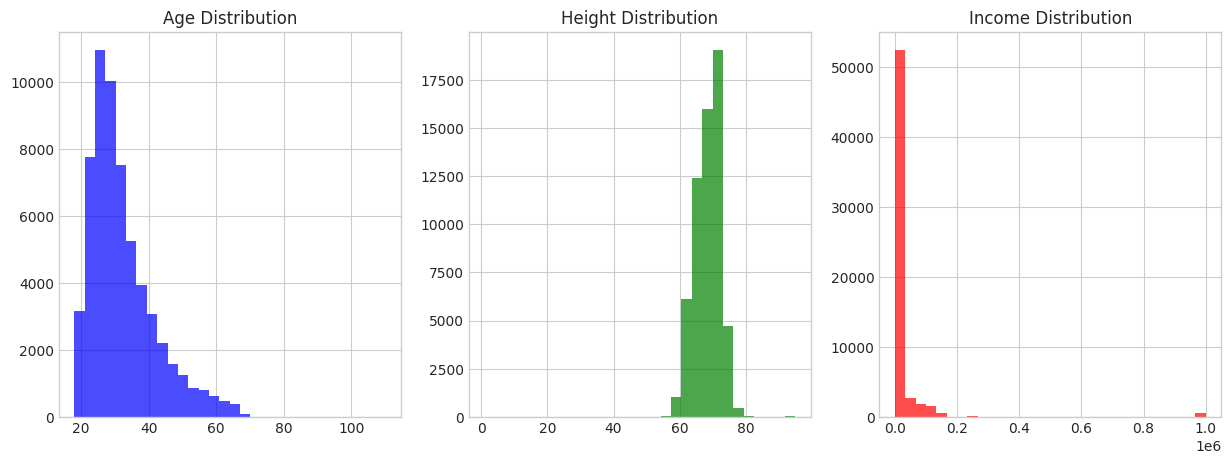

In [ ]:
# Check for missing values in numerical features
print(okcupid[['age', 'height', 'income']].isnull().sum())

# Plot histograms for numerical features
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(okcupid['age'], bins=30, color='blue', alpha=0.7)
plt.title('Age Distribution')

plt.subplot(1, 3, 2)
plt.hist(okcupid['height'], bins=30, color='green', alpha=0.7)
plt.title('Height Distribution')

plt.subplot(1, 3, 3)
plt.hist(okcupid['income'], bins=30, color='red', alpha=0.7)
plt.title('Income Distribution')

plt.show()

sex                0
orientation        0
body_type       5296
diet           24395
drinks          2985
drugs          14080
education       6628
ethnicity       5680
dtype: int64


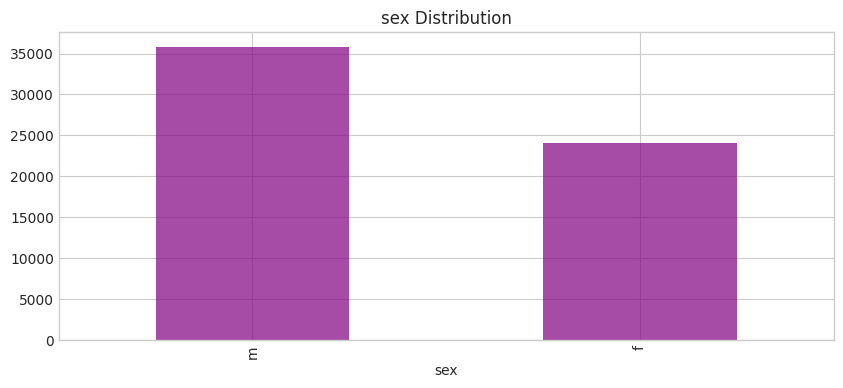

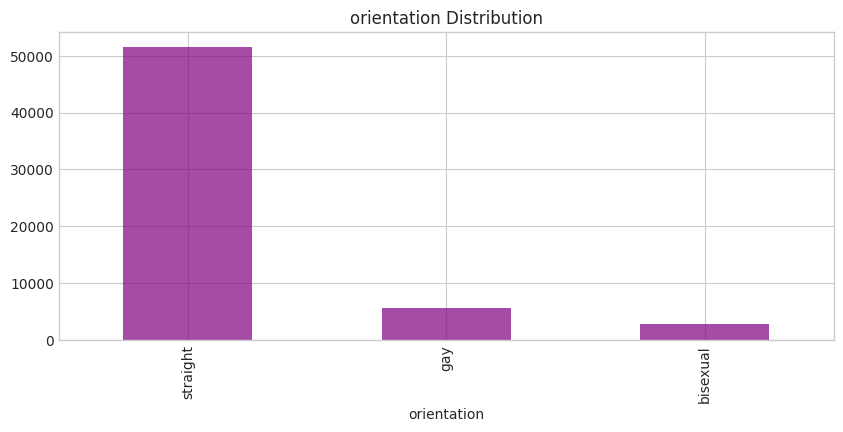

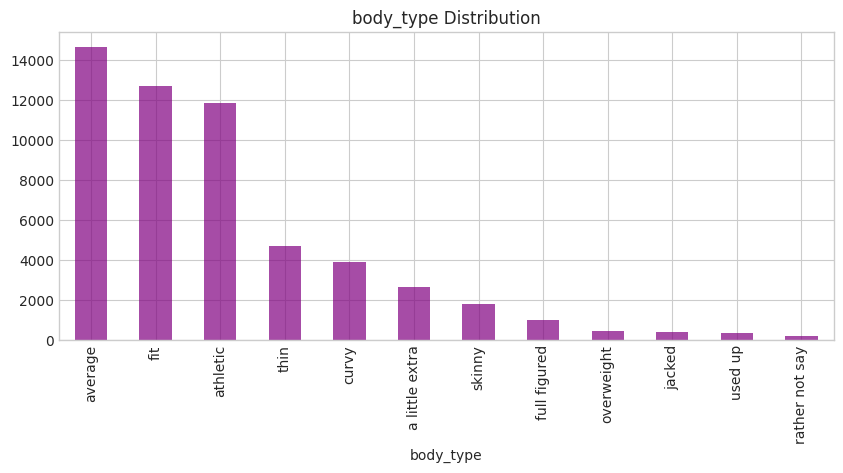

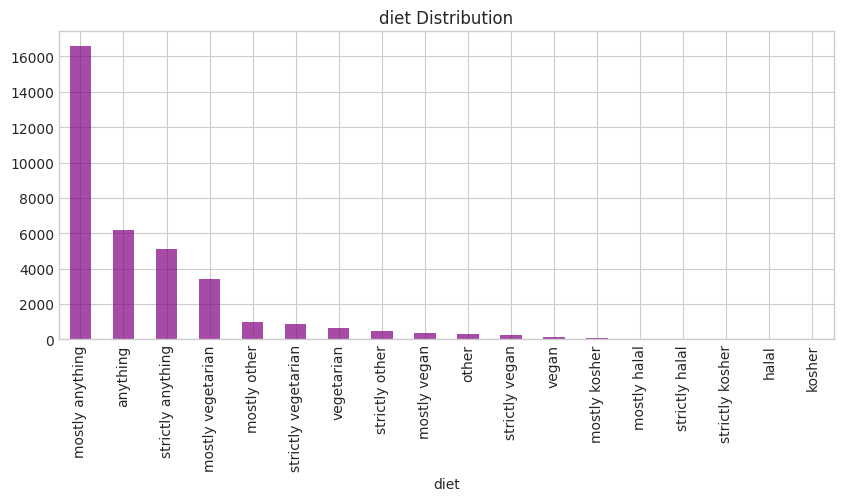

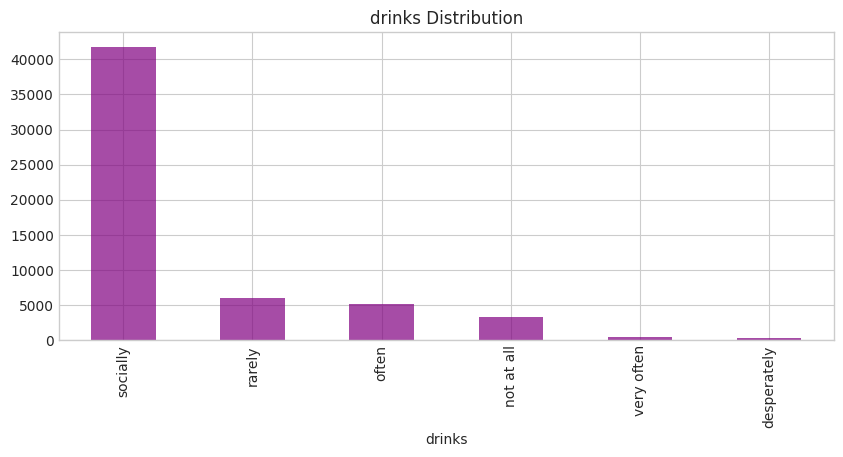

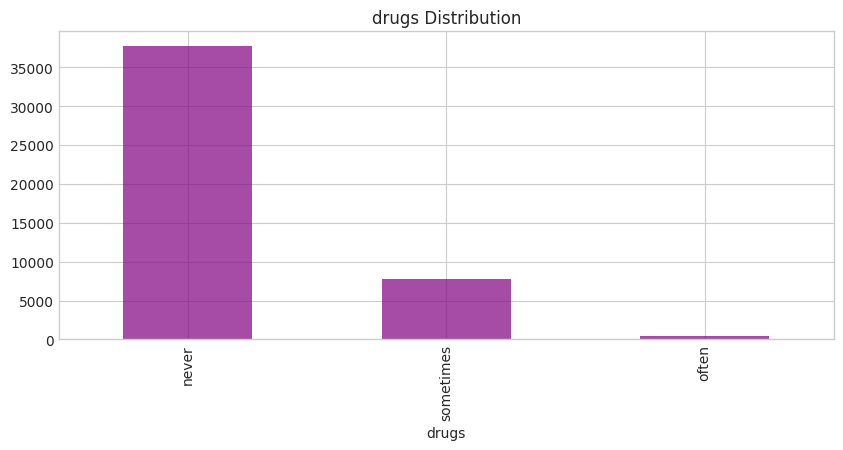

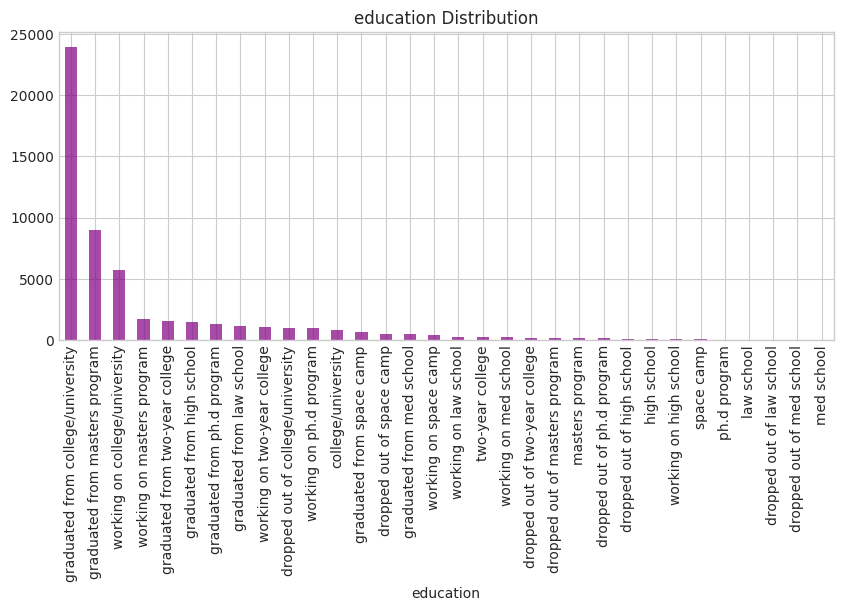

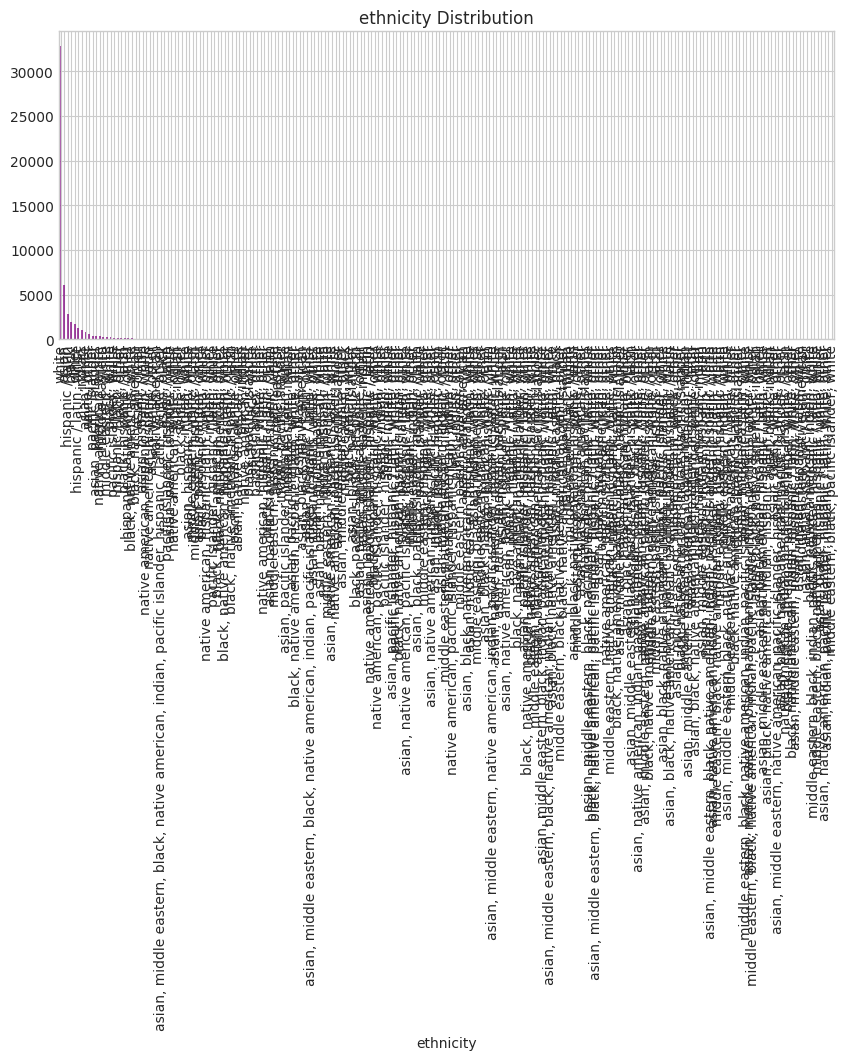

In [ ]:
# Check for missing values in categorical features
print(okcupid[['sex', 'orientation', 'body_type', 'diet', 'drinks', 'drugs', 'education', 'ethnicity']].isnull().sum())

# Plot value counts for categorical features
for col in ['sex', 'orientation', 'body_type', 'diet', 'drinks', 'drugs', 'education', 'ethnicity']:
    plt.figure(figsize=(10, 4))
    okcupid[col].value_counts().plot(kind='bar', color='purple', alpha=0.7)
    plt.title(f'{col} Distribution')
    plt.show()

1. Numerical Features

Observations:

Missing Values:
age: No missing values.
height: 3 missing values (negligible, can be imputed).
income: No missing values.
Outliers:
age and height: No outliers.
income: Has extreme values (e.g., -1 and 1,000,000). These are likely placeholders for missing or unknown values.

Impute Missing Values:
For height: Fill the 3 missing values with the median height.

In [ ]:
okcupid['height'].fillna(okcupid['height'].median(), inplace=True)

<ipython-input-85-d65d252ef9b0>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  okcupid['height'].fillna(okcupid['height'].median(), inplace=True)


Handle Outliers in income:
Replace -1 (unknown income) with NaN and then impute with the median.

In [ ]:
okcupid['income'].replace(-1, np.nan, inplace=True)
okcupid['income'].fillna(okcupid['income'].median(), inplace=True)

<ipython-input-86-951c203f55a8>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  okcupid['income'].replace(-1, np.nan, inplace=True)


Cap extreme values (e.g., 1,000,000) to a reasonable upper limit (e.g., 95th percentile).

In [ ]:
income_upper_limit = okcupid['income'].quantile(0.95)
okcupid['income'] = np.where(okcupid['income'] > income_upper_limit, income_upper_limit, okcupid['income'])

2. Categorical Features

Observations:

Missing Values:
body_type: 5,296 missing values.
diet: 24,395 missing values.
drinks: 2,985 missing values.
drugs: 14,080 missing values.
education: 6,628 missing values.
ethnicity: 5,680 missing values.
Imbalance:
sex: More males than females (expected for dating apps).
orientation: Mostly straight, with fewer gay and bisexual datapoints.
Other categorical features are right-skewed (e.g., body_type, diet, etc.).

For columns with a small number of missing values (drinks, education, ethnicity), fill with a placeholder like "unknown".

In [ ]:
okcupid['drinks'].fillna('unknown', inplace=True)
okcupid['education'].fillna('unknown', inplace=True)
okcupid['ethnicity'].fillna('unknown', inplace=True)

<ipython-input-88-c6f2441feb9d>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  okcupid['drinks'].fillna('unknown', inplace=True)
<ipython-input-88-c6f2441feb9d>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

For columns with a large number of missing values (body_type, diet, drugs), consider dropping the column or filling with a placeholder. Since diet has too many missing values, we’ll drop it.

In [ ]:
# okcupid.drop(columns=['diet'], inplace=True)
okcupid['body_type'].fillna('unknown', inplace=True)
okcupid['drugs'].fillna('unknown', inplace=True)

<ipython-input-89-924c65aa7f1b>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  okcupid['body_type'].fillna('unknown', inplace=True)
<ipython-input-89-924c65aa7f1b>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

## Amber's Feature Selection

In [ ]:
!pip install --upgrade matplotlib
!pip install missingno
!pip install pyampute

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import math
import missingno as msno

from pyampute.exploration.mcar_statistical_tests import MCARTest
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer

Text(0.5, 1.0, 'Missing Value Matrix')

<Figure size 1800x1500 with 0 Axes>

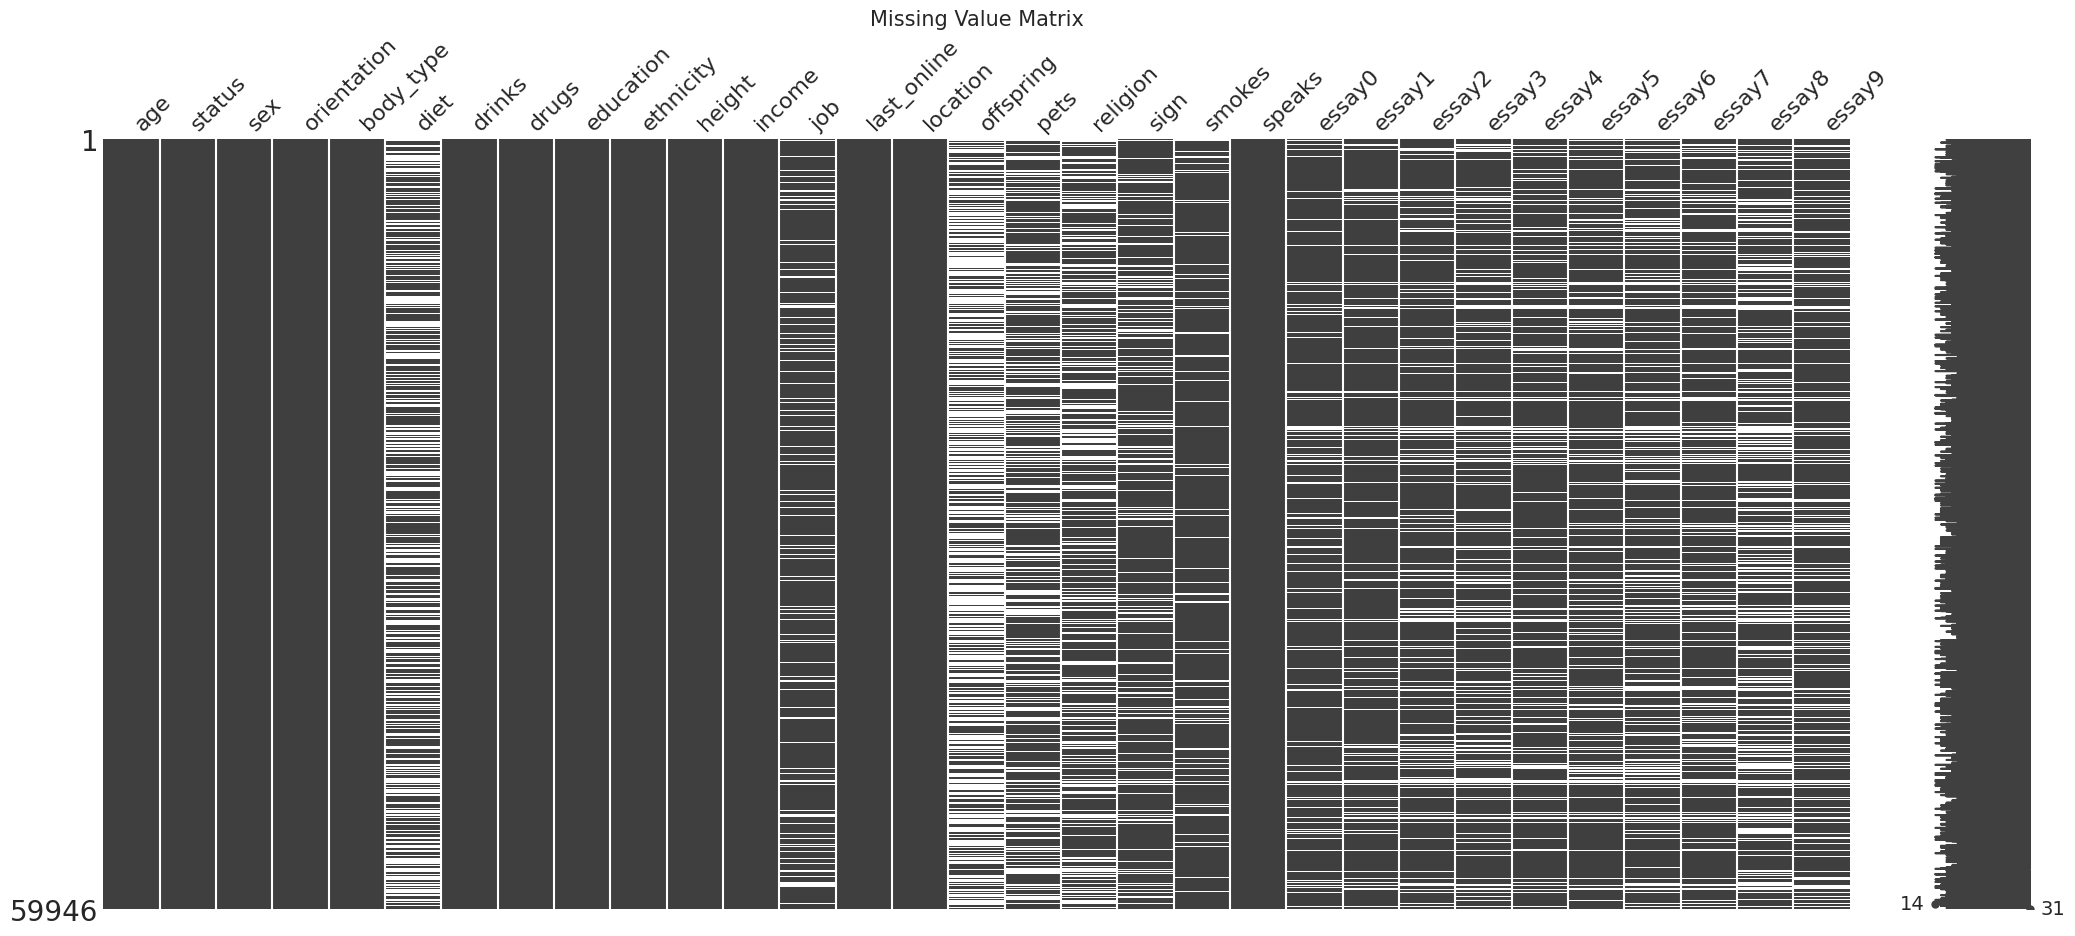

In [ ]:
plt.figure(figsize=(18, 15))
msno.matrix(okcupid)
plt.title('Missing Value Matrix', fontsize=15)

<Axes: >

<Figure size 1400x1200 with 0 Axes>

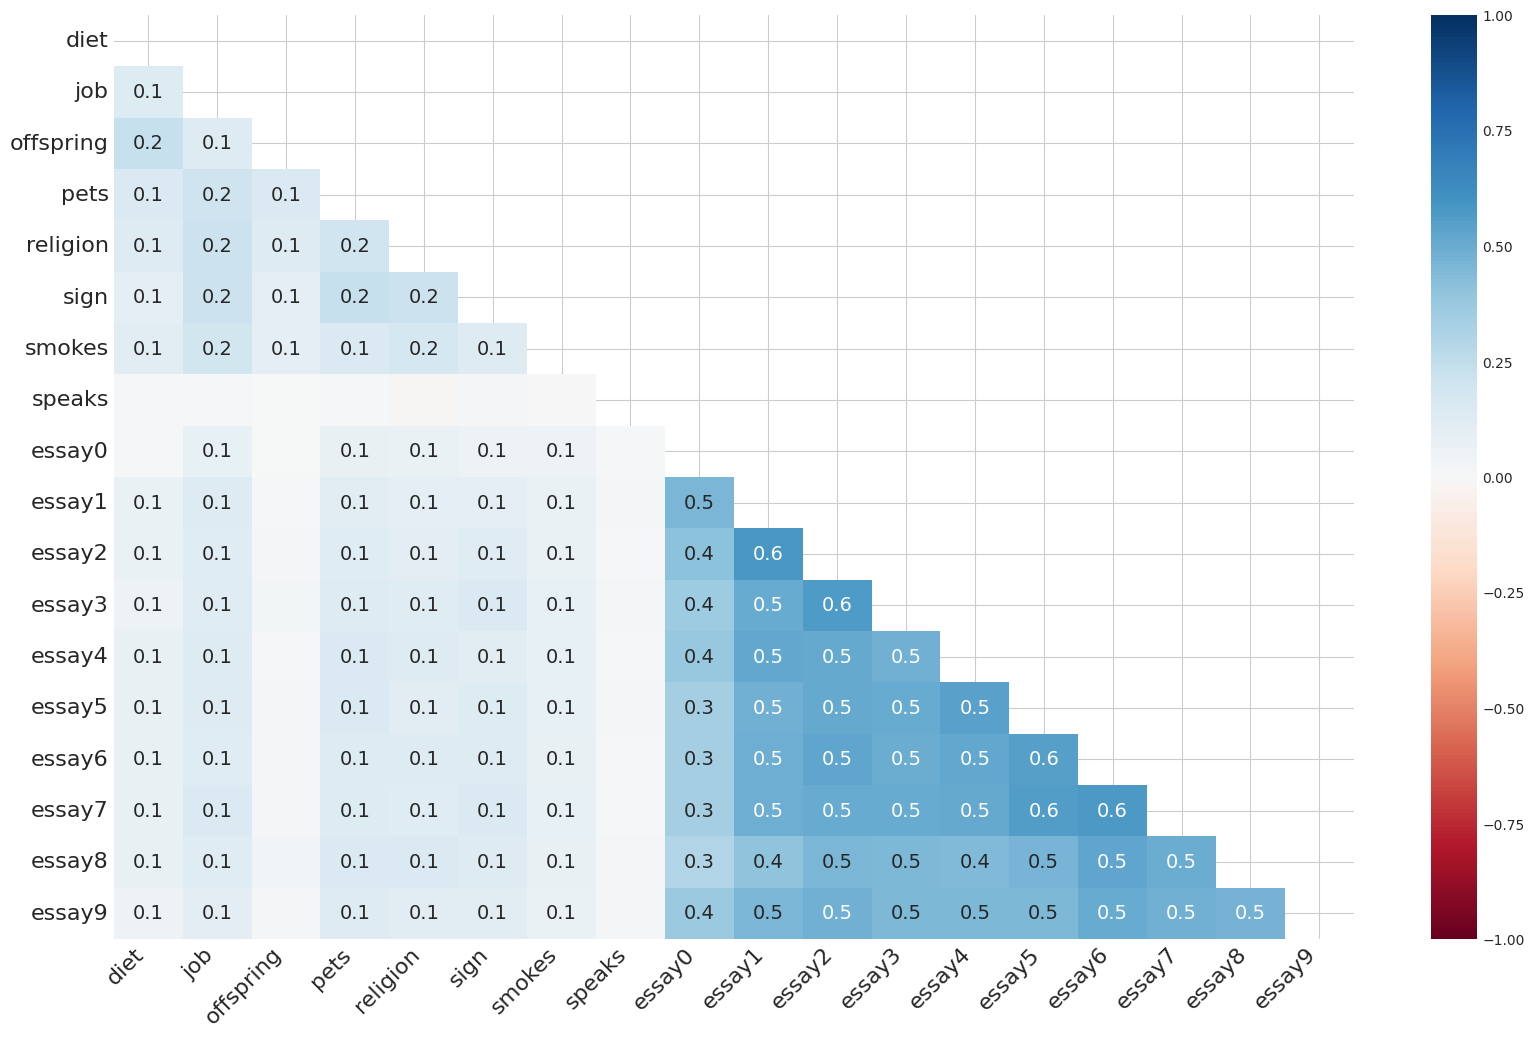

In [ ]:
plt.figure(figsize=(14, 12))
msno.heatmap(okcupid)

In [ ]:
missing_values = okcupid.isnull().sum()
missing_percent = (okcupid.isnull().sum() / len(okcupid) * 100)
missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing %': missing_percent.round(2)
}).sort_values('Missing Count', ascending=False)
print(missing_df)

             Missing Count  Missing %
offspring            35561      59.32
diet                 24395      40.69
religion             20226      33.74
pets                 19921      33.23
essay8               19225      32.07
essay6               13771      22.97
essay9               12603      21.02
essay7               12451      20.77
essay3               11476      19.14
sign                 11056      18.44
essay5               10850      18.10
essay4               10537      17.58
essay2                9638      16.08
job                   8198      13.68
essay1                7572      12.63
smokes                5512       9.19
essay0                5488       9.15
speaks                  50       0.08
location                 0       0.00
education                0       0.00
last_online              0       0.00
income                   0       0.00
height                   0       0.00
age                      0       0.00
body_type                0       0.00
orientation 

<Axes: >

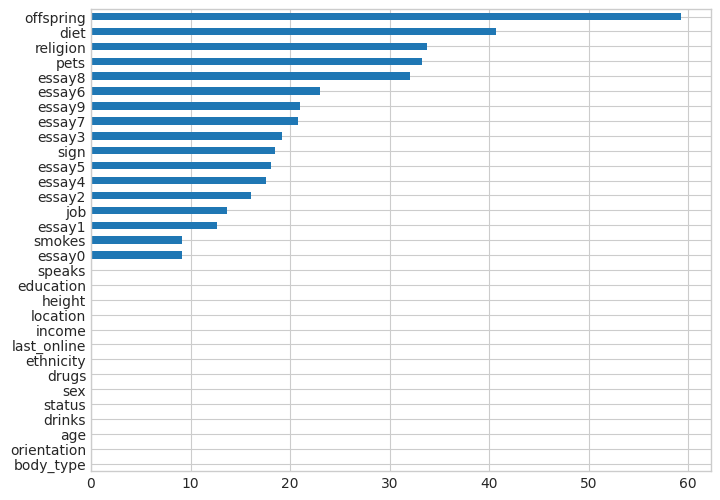

In [ ]:
plt.figure(figsize=(8, 6))
missing_df['Missing %'].sort_values(ascending=True).plot(kind='barh')

In [ ]:
# Create binary columns indicating missingness for key variables
missingness = okcupid.copy()

for var in missingness.columns:
    missingness[f'{var}_is_missing'] = missingness[var].isna().astype(int)
missingness.head()

,age,status,sex,orientation,body_type,diet,drinks,drugs,education,ethnicity,...,essay0_is_missing,essay1_is_missing,essay2_is_missing,essay3_is_missing,essay4_is_missing,essay5_is_missing,essay6_is_missing,essay7_is_missing,essay8_is_missing,essay9_is_missing
0,22,single,m,straight,a little extra,strictly anything,socially,never,working on college/university,"asian, white",...,0,0,0,0,0,0,0,0,0,0
1,35,single,m,straight,average,mostly other,often,sometimes,working on space camp,white,...,0,0,0,1,0,0,1,1,0,1
2,38,available,m,straight,thin,anything,socially,unknown,graduated from masters program,unknown,...,0,0,0,0,0,0,1,0,0,0
3,23,single,m,straight,thin,vegetarian,socially,unknown,working on college/university,white,...,0,0,0,0,0,1,0,1,1,0
4,29,single,m,straight,athletic,NaN,socially,never,graduated from college/university,"asian, black, other",...,0,0,0,0,0,1,1,1,1,1


In [ ]:
object_cols = okcupid.select_dtypes(include=['object'])
object_cols

numeric_cols = okcupid.select_dtypes(include=['float64', 'int64'])
numeric_cols

,age,height,income
0,22,75.0,50000.0
1,35,70.0,80000.0
2,38,68.0,50000.0
3,23,71.0,20000.0
4,29,66.0,50000.0
...,...,...,...
59941,59,62.0,50000.0
59942,24,72.0,50000.0
59943,42,71.0,80000.0
59944,27,73.0,50000.0


In [ ]:
for col in object_cols:
    okcupid[col] = okcupid[col].fillna('unknown')

okcupid.isna().sum()

,0
age,0
status,0
sex,0
orientation,0
body_type,0
diet,0
drinks,0
drugs,0
education,0
ethnicity,0


In [ ]:
# okcupid['speaks'].nunique()
okcupid['speaks'].value_counts()

,count
speaks,
english,21828
english (fluently),6628
"english (fluently), spanish (poorly)",2059
"english (fluently), spanish (okay)",1917
"english (fluently), spanish (fluently)",1288
...,...
"english (okay), chinese (okay), dutch (poorly), spanish (poorly)",1
"english (fluently), japanese (fluently), spanish (poorly), romanian (poorly), chinese (poorly)",1
"english (fluently), chinese (okay), french (fluently), thai (poorly)",1


In [ ]:
def extract_languages(text):
    if pd.isna(text):
        return []
    # Extract just the language names, not proficiency
    languages = []
    for part in str(text).split(','):
        # Extract the language name before any parentheses
        lang = part.strip().split(' (')[0].strip().lower()
        languages.append(lang)
    return languages

In [ ]:
okcupid['languages'] = okcupid['speaks'].apply(extract_languages)
okcupid['languages'].value_counts()

,count
languages,
[english],29072
"[english, spanish]",7831
"[english, french]",2291
"[english, chinese]",1726
"[english, german]",747
...,...
"[english, irish, portuguese, spanish, french]",1
"[english, hungarian, spanish, french, c++]",1
"[english, spanish, turkish, other]",1


In [ ]:
mlb = MultiLabelBinarizer()
lang_encoded = mlb.fit_transform(okcupid['languages'])
lang_df = pd.DataFrame(lang_encoded,
                           columns=mlb.classes_,
                           index=okcupid.index)
lang_df.shape

(59946, 78)

In [ ]:
lang_df.columns

Index(['afrikaans', 'albanian', 'ancient greek', 'arabic', 'armenian',
       'basque', 'belarusan', 'bengali', 'breton', 'bulgarian', 'c++',
       'catalan', 'cebuano', 'chechen', 'chinese', 'croatian', 'czech',
       'danish', 'dutch', 'english', 'esperanto', 'estonian', 'farsi',
       'finnish', 'french', 'frisian', 'georgian', 'german', 'greek',
       'gujarati', 'hawaiian', 'hebrew', 'hindi', 'hungarian', 'icelandic',
       'ilongo', 'indonesian', 'irish', 'italian', 'japanese', 'khmer',
       'korean', 'latin', 'latvian', 'lisp', 'lithuanian', 'malay', 'maori',
       'mongolian', 'norwegian', 'occitan', 'other', 'persian', 'polish',
       'portuguese', 'romanian', 'rotuman', 'russian', 'sanskrit', 'sardinian',
       'serbian', 'sign language', 'slovak', 'slovenian', 'spanish', 'swahili',
       'swedish', 'tagalog', 'tamil', 'thai', 'tibetan', 'turkish',
       'ukrainian', 'unknown', 'urdu', 'vietnamese', 'welsh', 'yiddish'],
      dtype='object')

In [ ]:
lang_df.sum().sort_values(ascending=False)

,0
english,59896
spanish,16312
french,7851
chinese,3660
german,3083
...,...
rotuman,12
armenian,11
breton,9
slovenian,8


In [ ]:
def extract_with_proficiency(text):
    if pd.isna(text):
        return {}
    result = {}
    for part in str(text).split(','):
        part = part.strip()
        if '(' in part and ')' in part:
            lang, level = part.split(' (')
            level = level.replace(')', '').strip()
            result[lang.strip().lower()] = level
        else:
            result[part.lower()] = 'mentioned'  # Default when no level is specified
    return result

In [ ]:
okcupid['lang_profc'] = okcupid['speaks'].apply(extract_with_proficiency)
okcupid['lang_profc'].value_counts()

,count
lang_profc,
{'english': 'mentioned'},21945
{'english': 'fluently'},6690
"{'english': 'fluently', 'spanish': 'poorly'}",2073
"{'english': 'fluently', 'spanish': 'okay'}",1928
"{'english': 'fluently', 'spanish': 'fluently'}",1292
...,...
"{'english': 'okay', 'chinese': 'okay', 'dutch': 'poorly', 'spanish': 'poorly'}",1
"{'english': 'fluently', 'japanese': 'fluently', 'spanish': 'poorly', 'romanian': 'poorly', 'chinese': 'poorly'}",1
"{'english': 'fluently', 'chinese': 'okay', 'french': 'fluently', 'thai': 'poorly'}",1


In [ ]:
top_languages = ['english', 'spanish', 'french', 'chinese', 'german']  # Determine from your data
proficiency_levels = ['fluently', 'okay', 'poorly']

## Binarises only top langs+profc combos.
for lang in top_languages:
    for level in proficiency_levels:
        column_name = f'speaks_{lang}_{level}'
        okcupid[column_name] = okcupid['lang_profc'].apply(
            lambda x: 1 if lang in x and x[lang] == level else 0
        )
okcupid.head()

,age,status,sex,orientation,body_type,diet,drinks,drugs,education,ethnicity,...,speaks_spanish_poorly,speaks_french_fluently,speaks_french_okay,speaks_french_poorly,speaks_chinese_fluently,speaks_chinese_okay,speaks_chinese_poorly,speaks_german_fluently,speaks_german_okay,speaks_german_poorly
0,22,single,m,straight,a little extra,strictly anything,socially,never,working on college/university,"asian, white",...,0,0,0,0,0,0,0,0,0,0
1,35,single,m,straight,average,mostly other,often,sometimes,working on space camp,white,...,1,0,0,1,0,0,0,0,0,0
2,38,available,m,straight,thin,anything,socially,unknown,graduated from masters program,unknown,...,0,0,0,0,0,0,0,0,0,0
3,23,single,m,straight,thin,vegetarian,socially,unknown,working on college/university,white,...,0,0,0,0,0,0,0,0,0,1
4,29,single,m,straight,athletic,unknown,socially,never,graduated from college/university,"asian, black, other",...,0,0,0,0,0,0,0,0,0,0


In [ ]:
okcupid.columns

Index(['age', 'status', 'sex', 'orientation', 'body_type', 'diet', 'drinks',
       'drugs', 'education', 'ethnicity', 'height', 'income', 'job',
       'last_online', 'location', 'offspring', 'pets', 'religion', 'sign',
       'smokes', 'speaks', 'essay0', 'essay1', 'essay2', 'essay3', 'essay4',
       'essay5', 'essay6', 'essay7', 'essay8', 'essay9', 'languages',
       'lang_profc', 'speaks_english_fluently', 'speaks_english_okay',
       'speaks_english_poorly', 'speaks_spanish_fluently',
       'speaks_spanish_okay', 'speaks_spanish_poorly',
       'speaks_french_fluently', 'speaks_french_okay', 'speaks_french_poorly',
       'speaks_chinese_fluently', 'speaks_chinese_okay',
       'speaks_chinese_poorly', 'speaks_german_fluently', 'speaks_german_okay',
       'speaks_german_poorly'],
      dtype='object')

In [ ]:
okc_features = okcupid.iloc[:, [4, 5, 6, 7, 8, 9, 12, 14, 15, 16,17]]
okc_features.head()

,body_type,diet,drinks,drugs,education,ethnicity,job,location,offspring,pets,religion
0,a little extra,strictly anything,socially,never,working on college/university,"asian, white",transportation,"south san francisco, california","doesn't have kids, but might want them",likes dogs and likes cats,agnosticism and very serious about it
1,average,mostly other,often,sometimes,working on space camp,white,hospitality / travel,"oakland, california","doesn't have kids, but might want them",likes dogs and likes cats,agnosticism but not too serious about it
2,thin,anything,socially,unknown,graduated from masters program,unknown,unknown,"san francisco, california",unknown,has cats,unknown
3,thin,vegetarian,socially,unknown,working on college/university,white,student,"berkeley, california",doesn't want kids,likes cats,unknown
4,athletic,unknown,socially,never,graduated from college/university,"asian, black, other",artistic / musical / writer,"san francisco, california",unknown,likes dogs and likes cats,unknown


In [ ]:
# ethnicity column
from sklearn.preprocessing import MultiLabelBinarizer

df0 = pd.DataFrame()

# Fill NaN values with an empty string and split the string by ', ' to create a list of labels
ethnicity = [str(d).split(', ') for d in okc_features["ethnicity"].fillna('')]

# Initialize the MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Fit and transform the data
encoded_data = mlb.fit_transform(ethnicity)

# Get the feature names
feature_names = mlb.classes_

# Create a DataFrame for better visualization (optional)
df0 = pd.DataFrame(encoded_data, columns=feature_names)

#print(df0)
print("Unique columns for 'df0':")
print(df0.columns)

Unique columns for 'df0':
Index(['asian', 'black', 'hispanic / latin', 'indian', 'middle eastern',
       'native american', 'other', 'pacific islander', 'unknown', 'white'],
      dtype='object')


In [ ]:
# offspring column
# Create DataFrame
df1 = pd.DataFrame()

# Define mapping for 'Has Kids' and 'Wants Kids'
mapping = {
    "doesn't have kids, but might want them": (0, 1),
    "doesn't have kids": (0, 0),
    "doesn't want kids": (0, 0),
    'has a kid': (1, 0),
    'has kids': (1, 0),
    "doesn't have kids, and doesn't want any": (0, 0),
    "doesn't have kids, but wants them": (0, 1),
    'has kids, and might want more': (1, 1),
    "has kids, but doesn't want more": (1, 0),
    'has a kid, and might want more': (1, 1),
    "has a kid, but doesn't want more": (1, 0),
    'has a kid, and wants more': (1, 1),
    'might want kids': (0, 1),
    'wants kids': (0, 1),
    'has kids, and wants more': (1, 1),
    'unknown': (0, 0)
}

# Apply mapping to create new columns
df1['Has Kids'] = okc_features['offspring'].map(lambda x: mapping[x][0])
df1['Wants Kids'] = okc_features['offspring'].map(lambda x: mapping[x][1])

# Display the DataFrame
print(df1)

       Has Kids  Wants Kids
0             0           1
1             0           1
2             0           0
3             0           0
4             0           0
...         ...         ...
59941         1           0
59942         0           0
59943         0           0
59944         0           1
59945         0           0

[59946 rows x 2 columns]


In [ ]:
# diet  column
df6 = pd.DataFrame()
df6['diet'] = okc_features['diet'].apply(lambda x: x.split()[-1])
okc_features.head()
print("Unique values for 'diet':")
print(df6['diet'].unique())
# label encode this column

Unique values for 'diet':
['anything' 'other' 'vegetarian' 'unknown' 'vegan' 'halal' 'kosher']


In [ ]:
# RELIGION  column
df7 = pd.DataFrame()
df7['religion'] = okc_features['religion'].str.split().str[0]
okc_features.head()
print("Unique values for 'religion':")
print(df7['religion'].unique())
# label encode this column


Unique values for 'religion':
['agnosticism' 'unknown' 'atheism' 'christianity' 'other' 'catholicism'
 'buddhism' 'judaism' 'hinduism' 'islam']


In [ ]:
# education column
print("Unique values for 'education':")
print(okc_features['education'].unique())
# categorize into high school, college, grad school, etc.
# Create DataFrame
df2 = pd.DataFrame()

# Define mapping of education descriptions to institution types
institution_mapping = {
    'high school': 'High School',
    'working on high school': 'High School',
    'dropped out of high school': 'High School',
    'two-year college': 'Two-Year College',
    'working on two-year college': 'Two-Year College',
    'dropped out of two-year college': 'Two-Year College',
    'college/university': 'College/University',
    'working on college/university': 'College/University',
    'dropped out of college/university': 'College/University',
    'graduated from college/university': 'College/University',
    'masters program': 'Graduate School',
    'working on masters program': 'Graduate School',
    'dropped out of masters program': 'Graduate School',
    'graduated from masters program': 'Graduate School',
    'ph.d program': 'Graduate School',
    'working on ph.d program': 'Graduate School',
    'dropped out of ph.d program': 'Graduate School',
    'graduated from ph.d program': 'Graduate School',
    'law school': 'Professional School',
    'working on law school': 'Professional School',
    'dropped out of law school': 'Professional School',
    'graduated from law school': 'Professional School',
    'med school': 'Professional School',
    'working on med school': 'Professional School',
    'dropped out of med school': 'Professional School',
    'graduated from med school': 'Professional School',
    'space camp': 'Other',
    'working on space camp': 'Other',
    'dropped out of space camp': 'Other',
    'graduated from space camp': 'Other'
}

# Map the 'education' column to 'institution_type' using the defined mapping
df2['institution_type'] = okc_features['education'].map(institution_mapping)

# Display the DataFrame with the new 'institution_type' column
print(df2)

# label encode!!!

Unique values for 'education':
['working on college/university' 'working on space camp'
 'graduated from masters program' 'graduated from college/university'
 'working on two-year college' 'unknown' 'graduated from high school'
 'working on masters program' 'graduated from space camp'
 'college/university' 'dropped out of space camp'
 'graduated from ph.d program' 'graduated from law school'
 'working on ph.d program' 'two-year college'
 'graduated from two-year college' 'working on med school'
 'dropped out of college/university' 'space camp'
 'graduated from med school' 'dropped out of high school'
 'working on high school' 'masters program' 'dropped out of ph.d program'
 'dropped out of two-year college' 'dropped out of med school'
 'high school' 'working on law school' 'law school'
 'dropped out of masters program' 'ph.d program'
 'dropped out of law school' 'med school']
         institution_type
0      College/University
1                   Other
2         Graduate School
3      

In [ ]:
print("\nUnique values for 'pets':")
print(okc_features['pets'].unique()) # feel like this is hard to analyze
# sentiment on liking / having or disliking / not having pets

# Create DataFrame
df3 = pd.DataFrame()

# Define mapping
mapping = {
    'likes dogs and likes cats': {'Has_Dogs': 0, 'Has_Cats': 0, 'Likes_Dogs': 1, 'Likes_Cats': 1},
    'likes dogs': {'Has_Dogs': 0, 'Has_Cats': 0, 'Likes_Dogs': 1, 'Likes_Cats': 0},
    'dislikes dogs and has cats': {'Has_Dogs': 0, 'Has_Cats': 1, 'Likes_Dogs': 0, 'Likes_Cats': 0},
    'has cats': {'Has_Dogs': 0, 'Has_Cats': 1, 'Likes_Dogs': 0, 'Likes_Cats': 0},
    'likes dogs and has cats': {'Has_Dogs': 0, 'Has_Cats': 1, 'Likes_Dogs': 1, 'Likes_Cats': 0},
    'has dogs and has cats': {'Has_Dogs': 1, 'Has_Cats': 1, 'Likes_Dogs': 0, 'Likes_Cats': 0},
    'has dogs and likes cats': {'Has_Dogs': 1, 'Has_Cats': 0, 'Likes_Dogs': 0, 'Likes_Cats': 1},
    'has dogs': {'Has_Dogs': 1, 'Has_Cats': 0, 'Likes_Dogs': 0, 'Likes_Cats': 0},
    'likes dogs and dislikes cats': {'Has_Dogs': 0, 'Has_Cats': 0, 'Likes_Dogs': 1, 'Likes_Cats': 0},
    'dislikes cats': {'Has_Dogs': 0, 'Has_Cats': 0, 'Likes_Dogs': 0, 'Likes_Cats': 0},
    'dislikes dogs and dislikes cats': {'Has_Dogs': 0, 'Has_Cats': 0, 'Likes_Dogs': 0, 'Likes_Cats': 0},
    'likes cats': {'Has_Dogs': 0, 'Has_Cats': 0, 'Likes_Dogs': 0, 'Likes_Cats': 1},
    'has dogs and dislikes cats': {'Has_Dogs': 1, 'Has_Cats': 0, 'Likes_Dogs': 0, 'Likes_Cats': 0},
    'dislikes dogs and likes cats': {'Has_Dogs': 0, 'Has_Cats': 0, 'Likes_Dogs': 0, 'Likes_Cats': 1},
    'dislikes dogs': {'Has_Dogs': 0, 'Has_Cats': 0, 'Likes_Dogs': 0, 'Likes_Cats': 0},
    'unknown': {'Has_Dogs': 0, 'Has_Cats': 0, 'Likes_Dogs': 0, 'Likes_Cats': 0}

}

# Apply mapping to DataFrame
for col in ['Has_Dogs', 'Has_Cats', 'Likes_Dogs', 'Likes_Cats']:
    df3[col] = okc_features['pets'].map(lambda x: mapping[x][col])

print(df3)


Unique values for 'pets':
['likes dogs and likes cats' 'has cats' 'likes cats' 'unknown'
 'has dogs and likes cats' 'likes dogs and has cats'
 'likes dogs and dislikes cats' 'has dogs' 'has dogs and dislikes cats'
 'likes dogs' 'has dogs and has cats' 'dislikes dogs and has cats'
 'dislikes dogs and dislikes cats' 'dislikes cats'
 'dislikes dogs and likes cats' 'dislikes dogs']
       Has_Dogs  Has_Cats  Likes_Dogs  Likes_Cats
0             0         0           1           1
1             0         0           1           1
2             0         1           0           0
3             0         0           0           1
4             0         0           1           1
...         ...       ...         ...         ...
59941         1         0           0           0
59942         0         0           1           1
59943         0         0           0           0
59944         0         0           1           1
59945         0         0           1           1

[59946 rows x 4 c

In [ ]:
print("Unique values for 'body_type':")
#print(okc_features['body_type'].unique()) # should we include this in the model?
# group rather not say into unknown

def simplify_body_type(body):
    if body in ['thin', 'skinny']:
        return 'Slim'
    elif body in ['average', 'fit']:
        return 'Average'
    elif body in ['athletic', 'jacked']:
        return 'Athletic'
    elif body in ['curvy', 'full figured', 'overweight', 'a little extra', 'used up']:
        return 'Curvy/Plus-Size'
    else:
        return 'Unknown/Prefer Not to Say'

df5 = pd.DataFrame()

df5['body_type_grouped'] = okc_features['body_type'].apply(simplify_body_type)
print(df5['body_type_grouped'].unique())


Unique values for 'body_type':
['Curvy/Plus-Size' 'Average' 'Slim' 'Athletic' 'Unknown/Prefer Not to Say']


In [ ]:
print("\nUnique values for 'job':")
#print(okc_features['job'].unique())

# Define job category mapping
job_mapping = {
    'science / tech / engineering': 'STEM',
    'computer / hardware / software': 'STEM',
    'banking / financial / real estate': 'Business & Finance',
    'sales / marketing / biz dev': 'Business & Finance',
    'executive / management': 'Business & Finance',
    'medicine / health': 'Healthcare & Wellness',
    'artistic / musical / writer': 'Creative & Arts',
    'entertainment / media': 'Creative & Arts',
    'education / academia': 'Education & Academia',
    'hospitality / travel': 'Service & Hospitality',
    'clerical / administrative': 'Service & Hospitality',
    'construction / craftsmanship': 'Trades & Manual Labor',
    'transportation': 'Trades & Manual Labor',
    'political / government': 'Government, Law, & Military',
    'law / legal services': 'Government, Law, & Military',
    'military': 'Government, Law, & Military',
    'student': 'Other & Unclassified',
    'unemployed': 'Other & Unclassified',
    'retired': 'Other & Unclassified',
    'rather not say': 'Other & Unclassified',
    'other': 'Other & Unclassified',
    'unknown': 'Other & Unclassified'
}
# Create DataFrame
df4 = pd.DataFrame()

# Apply the mapping to a new column
df4['job_category'] = okc_features['job'].map(job_mapping)

# Display the result
print(df4['job_category'].unique())



Unique values for 'job':
['Trades & Manual Labor' 'Service & Hospitality' 'Other & Unclassified'
 'Creative & Arts' 'STEM' 'Business & Finance' 'Healthcare & Wellness'
 'Education & Academia' 'Government, Law, & Military']


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Combine the specified dataframes and columns into a single dataframe
combined_df = pd.concat([df6, df7, df2, df5, df4, okcupid[['drinks', 'drugs', 'smokes']]], axis=1)

# Initialize the LabelEncoder
le = LabelEncoder()

# Apply label encoding to each column in the combined dataframe
for column in combined_df.columns:
    combined_df[column] = le.fit_transform(combined_df[column].astype(str))

# Display the resulting dataframe
print(combined_df.head())

   diet  religion  institution_type  body_type_grouped  job_category  drinks  \
0     0         0                 0                  2             8       4   
1     3         0                 3                  1             7       2   
2     0         9                 1                  3             5       4   
3     6         9                 0                  3             5       4   
4     4         9                 0                  0             1       4   

   drugs  smokes  
0      0       1  
1      2       0  
2      3       0  
3      3       0  
4      0       0  


In [ ]:
# Concatenate the dataframes
feature_embeddings = pd.concat([combined_df, df1, df3, df0], axis=1)

# Display the resulting dataframe
print(feature_embeddings.head())

   diet  religion  institution_type  body_type_grouped  job_category  drinks  \
0     0         0                 0                  2             8       4   
1     3         0                 3                  1             7       2   
2     0         9                 1                  3             5       4   
3     6         9                 0                  3             5       4   
4     4         9                 0                  0             1       4   

   drugs  smokes  Has Kids  Wants Kids  ...  asian  black  hispanic / latin  \
0      0       1         0           1  ...      1      0                 0   
1      2       0         0           1  ...      0      0                 0   
2      3       0         0           0  ...      0      0                 0   
3      3       0         0           0  ...      0      0                 0   
4      0       0         0           0  ...      1      1                 0   

   indian  middle eastern  native american  

## Compute Embeddings for Essays efficiently

In [ ]:
# Display the first few rows of the essay columns
okcupid[['essay0', 'essay1', 'essay2', 'essay3', 'essay4', 'essay5', 'essay6', 'essay7', 'essay8', 'essay9']].head()

,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9
0,about me: i would love to think that i was so...,currently working as an international agent fo...,making people laugh. ranting about a good salt...,"the way i look. i am a six foot half asian, ha...","books: absurdistan, the republic, of mice and ...",food. water. cell phone. shelter.,duality and humorous things,trying to find someone to hang out with. i am ...,i am new to california and looking for someone...,you want to be swept off your feet! you are ti...
1,i am a chef: this is what that means. 1. i am ...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,unknown,i am die hard christopher moore fan. i don't r...,delicious porkness in all of its glories. my b...,unknown,unknown,i am very open and will share just about anyth...,unknown
2,"i'm not ashamed of much, but writing public te...","i make nerdy software for musicians, artists, ...",improvising in different contexts. alternating...,my large jaw and large glasses are the physica...,okay this is where the cultural matrix gets so...,movement conversation creation contemplation t...,unknown,viewing. listening. dancing. talking. drinking...,"when i was five years old, i was known as ""the...","you are bright, open, intense, silly, ironic, ..."
3,i work in a library and go to school. . .,reading things written by old dead people,playing synthesizers and organizing books acco...,socially awkward but i do my best,"bataille, celine, beckett. . . lynch, jarmusch...",unknown,cats and german philosophy,unknown,unknown,you feel so inclined.
4,hey how's it going? currently vague on the pro...,work work work work + play,creating imagery to look at: http://bagsbrown....,i smile a lot and my inquisitive nature,"music: bands, rappers, musicians at the moment...",unknown,unknown,unknown,unknown,unknown


In [ ]:
# Create a new DataFrame for essays
essays_df = okcupid[['essay0', 'essay1', 'essay2', 'essay3', 'essay4', 'essay5', 'essay6', 'essay7', 'essay8', 'essay9']]

# Fill NA values in essays_df with empty strings
essays_df.fillna('', inplace=True)

<ipython-input-39-f7603d314aed>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  essays_df.fillna('', inplace=True)


In [ ]:
# Combine all essays into a single text column
essays_df['combined_essays'] = essays_df.apply(lambda row: ' '.join([row[f'essay{i}'] for i in range(10)]), axis=1)

<ipython-input-40-9e7f97ba2060>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  essays_df['combined_essays'] = essays_df.apply(lambda row: ' '.join([row[f'essay{i}'] for i in range(10)]), axis=1)


In [ ]:
pip install transformers torch numpy pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
from transformers import DistilBertTokenizer, DistilBertModel
import torch

# Load pre-trained DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
import numpy as np

# Function to generate embeddings in batches
def get_embeddings_in_batches(texts, batch_size=32):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]

        # Tokenize the batch and move to GPU
        inputs = tokenizer(batch, return_tensors='pt', truncation=True, padding=True, max_length=512).to(device)

        # Generate embeddings
        with torch.no_grad():
            outputs = model(**inputs)

        # Use the [CLS] token embedding as the sentence embedding
        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(batch_embeddings)

    # Concatenate all batch embeddings
    return np.vstack(embeddings)

# Generate embeddings for all essays
essay_embeddings = get_embeddings_in_batches(essays_df['combined_essays'].tolist(), batch_size=32)

# Check the shape
print(essay_embeddings.shape)  # Should be (num_users, 768)

(59946, 768)


In [ ]:
np.save('essay_embeddings.npy', essay_embeddings)

In [ ]:
essay_embeddings = np.load('essay_embeddings.npy')

## Feature Encoding and Combining Features



**Which Encoding Method to Use?**

| **Method**            | **Best For**                          | **Dimensionality** | **Interpretability** |
|------------------------|---------------------------------------|--------------------|-----------------------|
| **One-Hot Encoding**   | Low-cardinality features              | High               | High                  |
| **Target Encoding**    | Features with a target variable       | Low                | Medium                |
| **Frequency Encoding** | High-cardinality features             | Low                | Medium                |
| **Label Encoding**     | Ordinal features                     | Low                | Low                   |
| **Binary Encoding**    | High-cardinality features             | Medium             | Medium                |
| **Embedding Encoding** | High-cardinality features             | Low                | Low                   |
| **Hashing Encoding**   | Very high-cardinality features        | Fixed              | Low                   |
| **Leave-One-Out**      | Features with a target variable       | Low                | Medium                |

---

**Recommendation for Your Dataset**
1. **Low-Cardinality Features** (e.g., `sex`, `orientation`):
   - Use **one-hot encoding** or **binary encoding**.

2. **High-Cardinality Features** (e.g., `location`, `job`):
   - Use **frequency encoding**, **hashing encoding**, or **embedding encoding**.

3. **Features with a Target Variable**:
   - Use **target encoding** or **leave-one-out encoding**.


In [ ]:
essay_embeddings = np.load('/content/drive/MyDrive/OKCupid Project/essay_embeddings.npy')

We’ll use one-hot encoding for categorical features like sex, orientation, body_type, etc.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Dont have to run this anymore
from sklearn.preprocessing import OneHotEncoder

# Select categorical features
categorical_features = okcupid[['sex', 'orientation', 'body_type', 'drinks', 'drugs', 'education', 'ethnicity']]

# Initialize OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)  # Use sparse_output instead of sparse

# Fit and transform categorical features
categorical_encoded = encoder.fit_transform(categorical_features)

# Check the shape of the encoded features
print(categorical_encoded.shape)  # Should be (num_users, num_categories)

(59946, 280)


standardize the numerical features (age, height, income) so they are on the same scale.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Select numerical features
numerical_features = okcupid[['age', 'height', 'income']]

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform numerical features
numerical_encoded = scaler.fit_transform(numerical_features)

# Check the shape of the encoded features
print(numerical_encoded.shape)  # Should be (num_users, 3)

(59946, 3)


We’ll combine:

Essay embeddings (essay_embeddings): Shape (59946, 768).
One-hot encoded categorical features (categorical_encoded): Shape (59946, 280).
Standardized numerical features (numerical_encoded): Shape (59946, 3).
The combined feature matrix will have the shape (59946, 768 + 280 + 3) = (59946, 1051).

In [ ]:
import numpy as np

# Combine essay embeddings, categorical features, and numerical features
combined_features = np.hstack((essay_embeddings, feature_embeddings, numerical_encoded))

# Check the shape of the combined features
print(combined_features.shape)  # Should be (59946, 1051)

(59946, 795)


## Compute Cosine Similarity

### Cosine Similarity

Computing the full cosine similarity matrix for 59,946 users requires a lot of memory. A (59946, 59946) matrix with float32 values would require approximately:

59946×59946×4 bytes≈13.4 GB

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Define batch size
batch_size = 1000  # Adjust based on your system's memory
num_users = combined_features.shape[0]

# Initialize an empty similarity matrix
similarity_matrix = np.zeros((num_users, num_users), dtype=np.float32)

# Compute cosine similarity in batches
for i in range(0, num_users, batch_size):
    for j in range(0, num_users, batch_size):
        # Compute similarity for the current batch
        batch_similarity = cosine_similarity(
            combined_features[i:i + batch_size],
            combined_features[j:j + batch_size]
        )
        # Store the result in the similarity matrix
        similarity_matrix[i:i + batch_size, j:j + batch_size] = batch_similarity

# Check the shape of the similarity matrix
print(similarity_matrix.shape)  # Should be (59946, 59946)

Use Approximate Nearest Neighbors (FAISS)

If the batch approach is still too slow or memory-intensive, we can use FAISS (a library for efficient similarity search) to find the top matches without computing the full similarity matrix.

In [ ]:
pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 30.0 MB/s eta 0:00:00


### Test train and evaluate FIASS

In [ ]:
pip install faiss-cpu

In [ ]:
import numpy as np
import faiss
from sklearn.model_selection import train_test_split

# -------------------------------
# Step 1: Train-Test Split
train_indices, test_user_indices = train_test_split(okcupid.index, test_size=0.2, random_state=42)
train_data = combined_features[train_indices]
test_data = combined_features[test_user_indices]

# -------------------------------
# Step 2: Build FAISS Index on Training Data
train_data_norm = train_data / np.linalg.norm(train_data, axis=1, keepdims=True)
index = faiss.IndexFlatIP(train_data_norm.shape[1])
index.add(train_data_norm.astype(np.float32))

# -------------------------------
# Step 3: Define Helper Function: filter_matches
def filter_matches(user_index, candidate_indices, candidate_distances, okcupid, k):
    # Get user's gender and orientation
    user_gender = okcupid.loc[user_index, 'sex']
    user_orientation = okcupid.loc[user_index, 'orientation']

    if user_orientation == 'straight':
        preferred_gender = 'f' if user_gender == 'm' else 'm'
    elif user_orientation == 'gay':
        preferred_gender = user_gender
    elif user_orientation == 'bisexual':
        preferred_gender = None
    else:
        preferred_gender = None

    # Use only the top-k candidates
    top_k_candidates = candidate_indices[:k]
    top_k_similarities = candidate_distances[:k]

    # Filter matches based on preferred gender, if applicable
    if preferred_gender:
        filtered_matches = [match for match in top_k_candidates if okcupid.loc[match, 'sex'] == preferred_gender]
        filtered_similarities = [top_k_similarities[list(top_k_candidates).index(match)] for match in filtered_matches]
    else:
        filtered_matches = top_k_candidates
        filtered_similarities = top_k_similarities

    # Sort the filtered matches by similarity descending
    sorted_pairs = sorted(zip(filtered_similarities, filtered_matches), reverse=True)
    if sorted_pairs:
        filtered_similarities_sorted, filtered_matches_sorted = zip(*sorted_pairs)
        return list(filtered_matches_sorted), list(filtered_similarities_sorted)
    else:
        return [], []

# -------------------------------
# Step 4: Evaluate on Test Data
test_data_norm = test_data / np.linalg.norm(test_data, axis=1, keepdims=True)
k = 10
test_distances, test_search_indices = index.search(test_data_norm.astype(np.float32), k)

def evaluate_recommendations(search_indices, distances, test_user_indices, okcupid, k, sim_threshold=0.95):
    precision_scores = []
    recall_scores = []

    for i, user_index in enumerate(test_user_indices):
        top_k_matches = search_indices[i]
        top_k_similarities = distances[i]

        # Filter matches based on user profile details
        filtered_matches, _ = filter_matches(user_index, top_k_matches, top_k_similarities, okcupid, k)
        # Define relevance based on similarity threshold
        relevant_matches = [match for match, sim in zip(top_k_matches, top_k_similarities) if sim > sim_threshold]

        precision = len(relevant_matches) / k
        recall = len(relevant_matches) / (len(relevant_matches) if len(relevant_matches) > 0 else 1)

        precision_scores.append(precision)
        recall_scores.append(recall)

    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    return avg_precision, avg_recall

avg_precision, avg_recall = evaluate_recommendations(test_search_indices, test_distances, test_user_indices, okcupid, k)
print(f"Average Precision@{k}: {avg_precision:.4f}")
print(f"Average Recall@{k}: {avg_recall:.4f}")

def calculate_map(search_indices, distances, test_user_indices, okcupid, k, similarity_threshold=0.95):
    average_precisions = []

    for i, user_index in enumerate(test_user_indices):
        top_k_matches = search_indices[i]
        top_k_similarities = distances[i]
        filtered_matches, _ = filter_matches(user_index, top_k_matches, top_k_similarities, okcupid, k)
        relevant_matches = [match for match, sim in zip(filtered_matches, top_k_similarities) if sim > similarity_threshold]

        precision_scores = []
        for rank in range(1, k + 1):
            relevant_at_rank = [match for match in filtered_matches[:rank] if match in relevant_matches]
            precision_scores.append(len(relevant_at_rank) / rank)
        average_precision = np.mean(precision_scores) if relevant_matches else 0
        average_precisions.append(average_precision)

    map_score = np.mean(average_precisions)
    return map_score

map_score = calculate_map(test_search_indices, test_distances, test_user_indices, okcupid, k)
print(f"Mean Average Precision (MAP): {map_score:.4f}")

def calculate_mrr(search_indices, distances, test_user_indices, okcupid, k, similarity_threshold=0.95):
    reciprocal_ranks = []

    for i, user_index in enumerate(test_user_indices):
        top_k_matches = search_indices[i]
        top_k_similarities = distances[i]
        filtered_matches, _ = filter_matches(user_index, top_k_matches, top_k_similarities, okcupid, k)
        relevant_matches = [match for match, sim in zip(filtered_matches, top_k_similarities) if sim > similarity_threshold]
        if relevant_matches:
            first_relevant_rank = filtered_matches.index(relevant_matches[0]) + 1
            reciprocal_ranks.append(1 / first_relevant_rank)
        else:
            reciprocal_ranks.append(0)

    mrr_score = np.mean(reciprocal_ranks)
    return mrr_score

mrr_score = calculate_mrr(test_search_indices, test_distances, test_user_indices, okcupid, k)
print(f"Mean Reciprocal Rank (MRR): {mrr_score:.4f}")

def calculate_coverage(search_indices, test_user_indices, okcupid, k):
    unique_recommended_items = set()
    for i, user_index in enumerate(test_user_indices):
        top_k_matches = search_indices[i][:k]
        unique_recommended_items.update(top_k_matches)
    coverage = len(unique_recommended_items) / len(okcupid)
    return coverage

coverage = calculate_coverage(test_search_indices, test_user_indices, okcupid, k)
print(f"Coverage: {coverage:.4f}")

Average Precision@10: 0.9437
Average Recall@10: 0.9744
Mean Average Precision (MAP): 0.7550
Mean Reciprocal Rank (MRR): 0.9703
Coverage: 0.5663


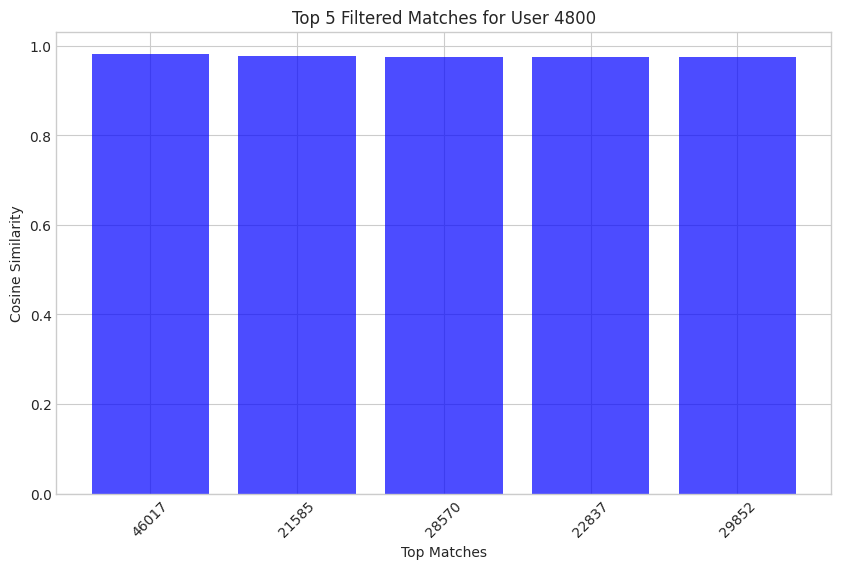

In [ ]:
import matplotlib.pyplot as plt

# Select a user from the test set
user_index = test_user_indices[0]  # First user in the test set

# Get the top matches and their similarity scores
filtered_matches, filtered_similarities = filter_matches(user_index, test_search_indices[0], test_distances[0], okcupid, k)

# Plot the similarity scores
plt.figure(figsize=(10, 6))
plt.bar(range(len(filtered_matches)), filtered_similarities, color='blue', alpha=0.7)
plt.xlabel('Top Matches')
plt.ylabel('Cosine Similarity')
plt.title(f'Top {len(filtered_matches)} Filtered Matches for User {user_index}')
plt.xticks(range(len(filtered_matches)), filtered_matches, rotation=45)
plt.show()

### Weighted FAISS with Additional Metrics (Including F1)

In [ ]:
import numpy as np
import faiss
from sklearn.metrics import f1_score  # though we'll compute F1 manually per user

# -------------------------------
# Define weights for each feature block:
# Adjust these weights as needed.
weight_essay = 1.5      # weight for essay embeddings (768 dims)
weight_features = 1.0   # weight for engineered categorical features
weight_numeric = 0.5   # weight for numerical features

# Determine dimensions based on earlier concatenation:
essay_dim = essay_embeddings.shape[1]
num_numeric = numerical_encoded.shape[1]
# feature_embeddings dimension is inferred from combined_features:
feature_dim = combined_features.shape[1] - essay_dim - num_numeric

# Create a weighted combined features array:
weighted_combined_features = np.hstack((
    weight_essay * essay_embeddings,
    weight_features * feature_embeddings.to_numpy(),  # if feature_embeddings is a DataFrame
    weight_numeric * numerical_encoded
))
print("Weighted combined features shape:", weighted_combined_features.shape)

# -------------------------------
# Train-Test split (reuse indices from before)
from sklearn.model_selection import train_test_split
train_indices, test_user_indices = train_test_split(okcupid.index, test_size=0.2, random_state=42)
train_data = weighted_combined_features[train_indices]
test_data = weighted_combined_features[test_user_indices]

# Build FAISS index on weighted training data
train_data_norm = train_data / np.linalg.norm(train_data, axis=1, keepdims=True)
index = faiss.IndexFlatIP(train_data_norm.shape[1])
index.add(train_data_norm.astype(np.float32))

# For a chosen k (e.g., top 10 recommendations)
k = 10
test_data_norm = test_data / np.linalg.norm(test_data, axis=1, keepdims=True)
test_distances, test_search_indices = index.search(test_data_norm.astype(np.float32), k)

# -------------------------------
# Reuse your filtering function (make sure it's defined):
def filter_matches(user_index, candidate_indices, candidate_distances, okcupid, k):
    user_gender = okcupid.loc[user_index, 'sex']
    user_orientation = okcupid.loc[user_index, 'orientation']

    if user_orientation == 'straight':
        preferred_gender = 'f' if user_gender == 'm' else 'm'
    elif user_orientation == 'gay':
        preferred_gender = user_gender
    elif user_orientation == 'bisexual':
        preferred_gender = None
    else:
        preferred_gender = None

    top_k_candidates = candidate_indices[:k]
    top_k_similarities = candidate_distances[:k]

    if preferred_gender:
        filtered_matches = [match for match in top_k_candidates if okcupid.loc[match, 'sex'] == preferred_gender]
        filtered_similarities = [top_k_similarities[list(top_k_candidates).index(match)] for match in filtered_matches]
    else:
        filtered_matches = top_k_candidates
        filtered_similarities = top_k_similarities

    sorted_pairs = sorted(zip(filtered_similarities, filtered_matches), reverse=True)
    if sorted_pairs:
        filtered_similarities_sorted, filtered_matches_sorted = zip(*sorted_pairs)
        return list(filtered_matches_sorted), list(filtered_similarities_sorted)
    else:
        return [], []

# -------------------------------
# Evaluation metrics (adding F1):
def evaluate_recommendations(search_indices, distances, test_user_indices, okcupid, k, sim_threshold=0.95):
    precision_scores = []
    recall_scores = []
    f1_scores = []

    for i, user_index in enumerate(test_user_indices):
        top_k_matches = search_indices[i]
        top_k_similarities = distances[i]

        # Use the filter function:
        filtered_matches, filtered_sims = filter_matches(user_index, top_k_matches, top_k_similarities, okcupid, k)

        # Define relevance based on a similarity threshold:
        # Here, we mark a match as relevant if similarity > sim_threshold.
        relevant_matches = [match for match, sim in zip(top_k_matches, top_k_similarities) if sim > sim_threshold]

        precision = len(relevant_matches) / k
        recall = len(relevant_matches) / (len(relevant_matches) if len(relevant_matches) > 0 else 1)
        # F1: harmonic mean of precision and recall (if both > 0, else 0)
        f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0

        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    avg_f1 = np.mean(f1_scores)
    return avg_precision, avg_recall, avg_f1

# Additional metrics from your earlier code (MAP, MRR, Coverage):
def calculate_map(search_indices, distances, test_user_indices, okcupid, k, similarity_threshold=0.95):
    average_precisions = []
    for i, user_index in enumerate(test_user_indices):
        top_k_matches = search_indices[i]
        top_k_similarities = distances[i]
        filtered_matches, _ = filter_matches(user_index, top_k_matches, top_k_similarities, okcupid, k)
        relevant_matches = [match for match, sim in zip(filtered_matches, top_k_similarities) if sim > similarity_threshold]
        precision_scores = []
        for rank in range(1, k + 1):
            relevant_at_rank = [match for match in filtered_matches[:rank] if match in relevant_matches]
            precision_scores.append(len(relevant_at_rank) / rank)
        average_precision = np.mean(precision_scores) if relevant_matches else 0
        average_precisions.append(average_precision)
    return np.mean(average_precisions)

def calculate_mrr(search_indices, distances, test_user_indices, okcupid, k, similarity_threshold=0.95):
    reciprocal_ranks = []
    for i, user_index in enumerate(test_user_indices):
        top_k_matches = search_indices[i]
        top_k_similarities = distances[i]
        filtered_matches, _ = filter_matches(user_index, top_k_matches, top_k_similarities, okcupid, k)
        relevant_matches = [match for match, sim in zip(filtered_matches, top_k_similarities) if sim > similarity_threshold]
        if relevant_matches:
            first_relevant_rank = filtered_matches.index(relevant_matches[0]) + 1
            reciprocal_ranks.append(1 / first_relevant_rank)
        else:
            reciprocal_ranks.append(0)
    return np.mean(reciprocal_ranks)

def calculate_coverage(search_indices, test_user_indices, okcupid, k):
    unique_items = set()
    for i, user_index in enumerate(test_user_indices):
        top_k = search_indices[i][:k]
        unique_items.update(top_k)
    return len(unique_items) / len(okcupid)

# Calculate all metrics:
avg_precision, avg_recall, avg_f1 = evaluate_recommendations(test_search_indices, test_distances, test_user_indices, okcupid, k)
map_score = calculate_map(test_search_indices, test_distances, test_user_indices, okcupid, k)
mrr_score = calculate_mrr(test_search_indices, test_distances, test_user_indices, okcupid, k)
coverage = calculate_coverage(test_search_indices, test_user_indices, okcupid, k)

print(f"[Weighted FAISS Metrics] Precision@{k}: {avg_precision:.4f}")
print(f"[Weighted FAISS Metrics] Recall@{k}: {avg_recall:.4f}")
print(f"[Weighted FAISS Metrics] F1 Score@{k}: {avg_f1:.4f}")
print(f"[Weighted FAISS Metrics] MAP: {map_score:.4f}")
print(f"[Weighted FAISS Metrics] MRR: {mrr_score:.4f}")
print(f"[Weighted FAISS Metrics] Coverage: {coverage:.4f}")

Weighted combined features shape: (59946, 795)
[Weighted FAISS Metrics] Precision@10: 0.9673
[Weighted FAISS Metrics] Recall@10: 0.9823
[Weighted FAISS Metrics] F1 Score@10: 0.9705
[Weighted FAISS Metrics] MAP: 0.7645
[Weighted FAISS Metrics] MRR: 0.9790
[Weighted FAISS Metrics] Coverage: 0.5392


In [ ]:
import numpy as np
import faiss
from sklearn.model_selection import KFold
from sklearn.preprocessing import normalize

# --- Assume these variables are defined from your preprocessing ---
# essay_embeddings: NumPy array of shape (num_users, essay_dim)
# feature_embeddings: DataFrame or NumPy array of shape (num_users, feature_dim)
# numerical_encoded: NumPy array of shape (num_users, num_numeric)
# okcupid: original DataFrame with user info
# combined_features: original combined feature matrix (for dimension calculation)

# Evaluation functions (as defined in your code)
def filter_matches(user_index, candidate_indices, candidate_distances, okcupid, k):
    user_gender = okcupid.loc[user_index, 'sex']
    user_orientation = okcupid.loc[user_index, 'orientation']

    if user_orientation == 'straight':
        preferred_gender = 'f' if user_gender == 'm' else 'm'
    elif user_orientation == 'gay':
        preferred_gender = user_gender
    elif user_orientation == 'bisexual':
        preferred_gender = None
    else:
        preferred_gender = None

    top_k_candidates = candidate_indices[:k]
    top_k_similarities = candidate_distances[:k]

    if preferred_gender:
        filtered_matches = [match for match in top_k_candidates if okcupid.loc[match, 'sex'] == preferred_gender]
        filtered_similarities = [top_k_similarities[list(top_k_candidates).index(match)] for match in filtered_matches]
    else:
        filtered_matches = top_k_candidates
        filtered_similarities = top_k_similarities

    sorted_pairs = sorted(zip(filtered_similarities, filtered_matches), reverse=True)
    if sorted_pairs:
        filtered_similarities_sorted, filtered_matches_sorted = zip(*sorted_pairs)
        return list(filtered_matches_sorted), list(filtered_similarities_sorted)
    else:
        return [], []

def evaluate_recommendations(search_indices, distances, test_user_indices, okcupid, k, sim_threshold=0.95):
    precision_scores = []
    recall_scores = []
    f1_scores = []

    for i, user_index in enumerate(test_user_indices):
        top_k_matches = search_indices[i]
        top_k_similarities = distances[i]
        filtered_matches, filtered_sims = filter_matches(user_index, top_k_matches, top_k_similarities, okcupid, k)
        relevant_matches = [match for match, sim in zip(top_k_matches, top_k_similarities) if sim > sim_threshold]

        precision = len(relevant_matches) / k
        recall = len(relevant_matches) / (len(relevant_matches) if len(relevant_matches) > 0 else 1)
        f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0

        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    avg_f1 = np.mean(f1_scores)
    return avg_precision, avg_recall, avg_f1

def calculate_map(search_indices, distances, test_user_indices, okcupid, k, similarity_threshold=0.95):
    average_precisions = []
    for i, user_index in enumerate(test_user_indices):
        top_k_matches = search_indices[i]
        top_k_similarities = distances[i]
        filtered_matches, _ = filter_matches(user_index, top_k_matches, top_k_similarities, okcupid, k)
        relevant_matches = [match for match, sim in zip(filtered_matches, top_k_similarities) if sim > similarity_threshold]
        precision_scores = []
        for rank in range(1, k + 1):
            relevant_at_rank = [match for match in filtered_matches[:rank] if match in relevant_matches]
            precision_scores.append(len(relevant_at_rank) / rank)
        average_precision = np.mean(precision_scores) if relevant_matches else 0
        average_precisions.append(average_precision)
    return np.mean(average_precisions)

def calculate_mrr(search_indices, distances, test_user_indices, okcupid, k, similarity_threshold=0.95):
    reciprocal_ranks = []
    for i, user_index in enumerate(test_user_indices):
        top_k_matches = search_indices[i]
        top_k_similarities = distances[i]
        filtered_matches, _ = filter_matches(user_index, top_k_matches, top_k_similarities, okcupid, k)
        relevant_matches = [match for match, sim in zip(filtered_matches, top_k_similarities) if sim > similarity_threshold]
        if relevant_matches:
            first_relevant_rank = filtered_matches.index(relevant_matches[0]) + 1
            reciprocal_ranks.append(1 / first_relevant_rank)
        else:
            reciprocal_ranks.append(0)
    return np.mean(reciprocal_ranks)

def calculate_coverage(search_indices, test_user_indices, okcupid, k):
    unique_items = set()
    for i, user_index in enumerate(test_user_indices):
        top_k = search_indices[i][:k]
        unique_items.update(top_k)
    return len(unique_items) / len(okcupid)

# --- Function to perform k-fold CV on Weighted FAISS ---
def cross_val_weighted_faiss(weight_essay, weight_features, weight_numeric, k_folds=5, k_recs=10, sim_threshold=0.95):
    # Combine all indices for cross validation:
    all_indices = np.array(okcupid.index)
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    metrics_list = []

    for train_idx, test_idx in kf.split(all_indices):
        # Build weighted features for the current fold:
        train_indices_cv = all_indices[train_idx]
        test_indices_cv = all_indices[test_idx]

        weighted_features = np.hstack((
            weight_essay * essay_embeddings[train_idx.tolist() + test_idx.tolist()][:len(train_indices_cv)+len(test_indices_cv)] if False else
            weight_essay * essay_embeddings,  # Use full arrays with indexing based on global indices
            weight_features * feature_embeddings.to_numpy(),
            weight_numeric * numerical_encoded
        ))
        # Instead, since our essay_embeddings, feature_embeddings, numerical_encoded align with okcupid.index,
        # we can simply index them:
        weighted_features_cv = np.hstack((
            weight_essay * essay_embeddings[train_idx.tolist() + test_idx.tolist()],
            weight_features * feature_embeddings.to_numpy()[train_idx.tolist() + test_idx.tolist()],
            weight_numeric * numerical_encoded[train_idx.tolist() + test_idx.tolist()]
        ))
        # Now, split for this fold:
        train_data_cv = weighted_features_cv[:len(train_indices_cv)]
        test_data_cv = weighted_features_cv[len(train_indices_cv):]

        # Normalize training and test data:
        train_data_norm = train_data_cv / np.linalg.norm(train_data_cv, axis=1, keepdims=True)
        test_data_norm = test_data_cv / np.linalg.norm(test_data_cv, axis=1, keepdims=True)

        # Build FAISS index on training fold:
        index_cv = faiss.IndexFlatIP(train_data_norm.shape[1])
        index_cv.add(train_data_norm.astype(np.float32))

        # Perform search for top-k recommendations:
        test_distances_cv, test_search_indices_cv = index_cv.search(test_data_norm.astype(np.float32), k_recs)

        # Evaluate fold metrics:
        fold_precision, fold_recall, fold_f1 = evaluate_recommendations(
            test_search_indices_cv, test_distances_cv, test_indices_cv, okcupid, k_recs, sim_threshold
        )
        fold_map = calculate_map(test_search_indices_cv, test_distances_cv, test_indices_cv, okcupid, k_recs, sim_threshold)
        fold_mrr = calculate_mrr(test_search_indices_cv, test_distances_cv, test_indices_cv, okcupid, k_recs, sim_threshold)
        fold_coverage = calculate_coverage(test_search_indices_cv, test_indices_cv, okcupid, k_recs)

        metrics_list.append({
            'precision': fold_precision,
            'recall': fold_recall,
            'f1': fold_f1,
            'map': fold_map,
            'mrr': fold_mrr,
            'coverage': fold_coverage
        })

    # Average metrics over folds:
    avg_precision = np.mean([m['precision'] for m in metrics_list])
    avg_recall = np.mean([m['recall'] for m in metrics_list])
    avg_f1 = np.mean([m['f1'] for m in metrics_list])
    avg_map = np.mean([m['map'] for m in metrics_list])
    avg_mrr = np.mean([m['mrr'] for m in metrics_list])
    avg_coverage = np.mean([m['coverage'] for m in metrics_list])

    return {
        'precision': avg_precision,
        'recall': avg_recall,
        'f1': avg_f1,
        'map': avg_map,
        'mrr': avg_mrr,
        'coverage': avg_coverage
    }

# --- Example: Run cross validation with given weights ---
weights = {
    'weight_essay': 2.0,
    'weight_features': 1.0,
    'weight_numeric': 1.0
}

cv_metrics = cross_val_weighted_faiss(weights['weight_essay'], weights['weight_features'], weights['weight_numeric'],
                                      k_folds=5, k_recs=10, sim_threshold=0.95)

print("Cross-Validated Metrics for Weighted FAISS:")
print(f"Precision@10: {cv_metrics['precision']:.4f}")
print(f"Recall@10: {cv_metrics['recall']:.4f}")
print(f"F1 Score@10: {cv_metrics['f1']:.4f}")
print(f"MAP: {cv_metrics['map']:.4f}")
print(f"MRR: {cv_metrics['mrr']:.4f}")
print(f"Coverage: {cv_metrics['coverage']:.4f}")

Cross-Validated Metrics for Weighted FAISS:
Precision@10: 0.9631
Recall@10: 0.9788
F1 Score@10: 0.9663
MAP: 0.7609
MRR: 0.9747
Coverage: 0.5357


### Hybrid Recommendation: FAISS + Collaborative Filtering

In [ ]:
from sklearn.preprocessing import normalize

# Parameters
alpha = 0.7      # weight for FAISS similarity (1 - alpha for CF)
top_n = 50       # expanded candidate pool size from FAISS
k = 10           # final number of recommendations

# --- Re-run FAISS search to get a larger candidate pool ---
# (Assumes test_data is from weighted_combined_features and is normalized)
test_data_norm = test_data / np.linalg.norm(test_data, axis=1, keepdims=True)
test_distances_extended, test_search_indices_extended = index.search(test_data_norm.astype(np.float32), top_n)

# --- Prepare CF similarity on the candidate pool ---
# Use previously normalized feature embeddings for CF similarity computation.
# (Assumes train_feature_emb_norm and test_feature_emb_norm are computed as in previous code.)
n_test = test_feature_emb_norm.shape[0]

hybrid_topk_indices = []
hybrid_topk_similarities = []

for i in range(n_test):
    # Get expanded candidate pool from FAISS for the i-th test sample.
    candidate_pool = test_search_indices_extended[i]   # shape: (top_n,)
    faiss_sim = test_distances_extended[i]              # shape: (top_n,)

    # Compute CF similarity for only these candidates:
    test_vec = test_feature_emb_norm[i].reshape(1, -1)    # shape: (1, d)
    candidate_vecs = train_feature_emb_norm[candidate_pool]  # shape: (top_n, d)
    cf_sim = (test_vec @ candidate_vecs.T).flatten()      # shape: (top_n,)

    # Compute the hybrid similarity:
    hybrid_sim = alpha * faiss_sim + (1 - alpha) * cf_sim

    # Re-rank the candidate pool by hybrid similarity and choose top-k:
    sorted_order = np.argsort(-hybrid_sim)
    final_topk = candidate_pool[sorted_order][:k]
    final_sim = hybrid_sim[sorted_order][:k]

    hybrid_topk_indices.append(final_topk)
    hybrid_topk_similarities.append(final_sim)

hybrid_topk_indices = np.array(hybrid_topk_indices)
hybrid_topk_similarities = np.array(hybrid_topk_similarities)

# --- Evaluate hybrid recommendations using your evaluation functions ---
avg_precision_h, avg_recall_h, avg_f1_h = evaluate_recommendations(
    hybrid_topk_indices, hybrid_topk_similarities, test_user_indices, okcupid, k
)
map_score_h = calculate_map(hybrid_topk_indices, hybrid_topk_similarities, test_user_indices, okcupid, k)
mrr_score_h = calculate_mrr(hybrid_topk_indices, hybrid_topk_similarities, test_user_indices, okcupid, k)
coverage_h = calculate_coverage(hybrid_topk_indices, test_user_indices, okcupid, k)

print("\n[Expanded Hybrid FAISS + CF Metrics]")
print(f"Precision@{k}: {avg_precision_h:.4f}")
print(f"Recall@{k}: {avg_recall_h:.4f}")
print(f"F1 Score@{k}: {avg_f1_h:.4f}")
print(f"MAP: {map_score_h:.4f}")
print(f"MRR: {mrr_score_h:.4f}")
print(f"Coverage: {coverage_h:.4f}")


[Expanded Hybrid FAISS + CF Metrics]
Precision@10: 0.9546
Recall@10: 0.9817
F1 Score@10: 0.9610
MAP: 0.7619
MRR: 0.9774
Coverage: 0.5389


Weighted FIASS with Grid Search

In [ ]:
import numpy as np
import faiss
from sklearn.model_selection import KFold


# --- Reuse the evaluation functions from your code ---
def filter_matches(user_index, candidate_indices, candidate_distances, okcupid, k):
    user_gender = okcupid.loc[user_index, 'sex']
    user_orientation = okcupid.loc[user_index, 'orientation']

    if user_orientation == 'straight':
        preferred_gender = 'f' if user_gender == 'm' else 'm'
    elif user_orientation == 'gay':
        preferred_gender = user_gender
    elif user_orientation == 'bisexual':
        preferred_gender = None
    else:
        preferred_gender = None

    top_k_candidates = candidate_indices[:k]
    top_k_similarities = candidate_distances[:k]

    if preferred_gender:
        filtered_matches = [match for match in top_k_candidates if okcupid.loc[match, 'sex'] == preferred_gender]
        filtered_similarities = [top_k_similarities[list(top_k_candidates).index(match)] for match in filtered_matches]
    else:
        filtered_matches = top_k_candidates
        filtered_similarities = top_k_similarities

    sorted_pairs = sorted(zip(filtered_similarities, filtered_matches), reverse=True)
    if sorted_pairs:
        filtered_similarities_sorted, filtered_matches_sorted = zip(*sorted_pairs)
        return list(filtered_matches_sorted), list(filtered_similarities_sorted)
    else:
        return [], []

def evaluate_recommendations(search_indices, distances, test_user_indices, okcupid, k, sim_threshold=0.95):
    precision_scores = []
    recall_scores = []
    f1_scores = []
    for i, user_index in enumerate(test_user_indices):
        top_k_matches = search_indices[i]
        top_k_similarities = distances[i]
        filtered_matches, _ = filter_matches(user_index, top_k_matches, top_k_similarities, okcupid, k)
        relevant_matches = [match for match, sim in zip(top_k_matches, top_k_similarities) if sim > sim_threshold]
        precision = len(relevant_matches) / k
        recall = len(relevant_matches) / (len(relevant_matches) if len(relevant_matches) > 0 else 1)
        f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
    return np.mean(precision_scores), np.mean(recall_scores), np.mean(f1_scores)

def calculate_map(search_indices, distances, test_user_indices, okcupid, k, similarity_threshold=0.95):
    average_precisions = []
    for i, user_index in enumerate(test_user_indices):
        top_k_matches = search_indices[i]
        top_k_similarities = distances[i]
        filtered_matches, _ = filter_matches(user_index, top_k_matches, top_k_similarities, okcupid, k)
        relevant_matches = [match for match, sim in zip(filtered_matches, top_k_similarities) if sim > similarity_threshold]
        precision_scores = []
        for rank in range(1, k + 1):
            relevant_at_rank = [match for match in filtered_matches[:rank] if match in relevant_matches]
            precision_scores.append(len(relevant_at_rank) / rank)
        average_precision = np.mean(precision_scores) if relevant_matches else 0
        average_precisions.append(average_precision)
    return np.mean(average_precisions)

def calculate_mrr(search_indices, distances, test_user_indices, okcupid, k, similarity_threshold=0.95):
    reciprocal_ranks = []
    for i, user_index in enumerate(test_user_indices):
        top_k_matches = search_indices[i]
        top_k_similarities = distances[i]
        filtered_matches, _ = filter_matches(user_index, top_k_matches, top_k_similarities, okcupid, k)
        relevant_matches = [match for match, sim in zip(filtered_matches, top_k_similarities) if sim > similarity_threshold]
        if relevant_matches:
            first_relevant_rank = filtered_matches.index(relevant_matches[0]) + 1
            reciprocal_ranks.append(1 / first_relevant_rank)
        else:
            reciprocal_ranks.append(0)
    return np.mean(reciprocal_ranks)

def calculate_coverage(search_indices, test_user_indices, okcupid, k):
    unique_items = set()
    for i, user_index in enumerate(test_user_indices):
        top_k = search_indices[i][:k]
        unique_items.update(top_k)
    return len(unique_items) / len(okcupid)

# --- Function to perform k-fold cross validation on Weighted FAISS ---
def cross_val_weighted_faiss(weight_essay, weight_features, weight_numeric, k_folds=5, k_recs=10, sim_threshold=0.95):
    all_indices = np.array(okcupid.index)
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    metrics_list = []
    for train_idx, test_idx in kf.split(all_indices):
        train_indices_cv = all_indices[train_idx]
        test_indices_cv = all_indices[test_idx]

        # Construct weighted feature matrix for the fold:
        weighted_features_cv = np.hstack((
            weight_essay * essay_embeddings[train_idx.tolist() + test_idx.tolist()],
            weight_features * feature_embeddings.to_numpy()[train_idx.tolist() + test_idx.tolist()],
            weight_numeric * numerical_encoded[train_idx.tolist() + test_idx.tolist()]
        ))
        n_train = len(train_indices_cv)
        train_data_cv = weighted_features_cv[:n_train]
        test_data_cv = weighted_features_cv[n_train:]

        # Normalize features
        train_data_norm = train_data_cv / np.linalg.norm(train_data_cv, axis=1, keepdims=True)
        test_data_norm = test_data_cv / np.linalg.norm(test_data_cv, axis=1, keepdims=True)

        # Build FAISS index on training fold
        index_cv = faiss.IndexFlatIP(train_data_norm.shape[1])
        index_cv.add(train_data_norm.astype(np.float32))

        # Search for top-k recommendations in test fold
        test_distances_cv, test_search_indices_cv = index_cv.search(test_data_norm.astype(np.float32), k_recs)

        # Evaluate metrics for the fold
        fold_precision, fold_recall, fold_f1 = evaluate_recommendations(
            test_search_indices_cv, test_distances_cv, test_indices_cv, okcupid, k_recs, sim_threshold
        )
        fold_map = calculate_map(test_search_indices_cv, test_distances_cv, test_indices_cv, okcupid, k_recs, sim_threshold)
        fold_mrr = calculate_mrr(test_search_indices_cv, test_distances_cv, test_indices_cv, okcupid, k_recs, sim_threshold)
        fold_coverage = calculate_coverage(test_search_indices_cv, test_indices_cv, okcupid, k_recs)

        metrics_list.append({
            'precision': fold_precision,
            'recall': fold_recall,
            'f1': fold_f1,
            'map': fold_map,
            'mrr': fold_mrr,
            'coverage': fold_coverage
        })

    # Average metrics over folds
    avg_precision = np.mean([m['precision'] for m in metrics_list])
    avg_recall = np.mean([m['recall'] for m in metrics_list])
    avg_f1 = np.mean([m['f1'] for m in metrics_list])
    avg_map = np.mean([m['map'] for m in metrics_list])
    avg_mrr = np.mean([m['mrr'] for m in metrics_list])
    avg_coverage = np.mean([m['coverage'] for m in metrics_list])

    return {
        'precision': avg_precision,
        'recall': avg_recall,
        'f1': avg_f1,
        'map': avg_map,
        'mrr': avg_mrr,
        'coverage': avg_coverage
    }

# --- Grid Search Setup ---
essay_weights = [1.0, 1.5, 2.0]
feature_weights = [0.5, 1.0, 1.5]
numeric_weights = [0.5, 1.0, 1.5]

best_map = 0
best_combo = None
results = []

for w_e in essay_weights:
    for w_f in feature_weights:
        for w_n in numeric_weights:
            cv_metrics = cross_val_weighted_faiss(w_e, w_f, w_n, k_folds=5, k_recs=10, sim_threshold=0.95)
            results.append((w_e, w_f, w_n, cv_metrics))
            print(f"Weights: Essay={w_e}, Features={w_f}, Numerics={w_n} -> MAP: {cv_metrics['map']:.4f}, MRR: {cv_metrics['mrr']:.4f}")
            if cv_metrics['map'] > best_map:
                best_map = cv_metrics['map']
                best_combo = (w_e, w_f, w_n)

print("Best combination:", best_combo, "with MAP:", best_map)

### Efficient Cosine Similarity Computation with Caching

In [ ]:
import os
import numpy as np
from sklearn.preprocessing import normalize

# Define a filename for the memory-mapped file:
cosine_sim_cache_file = "cosine_sim_memmap.npy"

# Extract weighted combined features for train and test sets
train_weighted = weighted_combined_features[train_indices]
test_weighted = weighted_combined_features[test_user_indices]

# Normalize train and test features (separately)
test_norm = normalize(test_weighted, axis=1)
train_norm = normalize(train_weighted, axis=1)

# Dimensions and batch settings
n_test = test_norm.shape[0]
n_train = train_norm.shape[0]
batch_size = 64  # Lower batch size to reduce memory usage

# Create or load the memory-mapped file:
if os.path.exists(cosine_sim_cache_file):
    # Load the existing memmap in read-only mode.
    cosine_sim_matrix = np.memmap(cosine_sim_cache_file, dtype='float32', mode='r', shape=(n_test, n_train))
    print("Loaded cosine similarity matrix from memmap cache.")
else:
    # Create a new memmap file in write mode.
    cosine_sim_matrix = np.memmap(cosine_sim_cache_file, dtype='float32', mode='w+', shape=(n_test, n_train))
    print("Computing cosine similarity matrix in batches...")
    for i in range(0, n_test, batch_size):
        batch = test_norm[i:i+batch_size]
        # Compute cosine similarity as dot product (since vectors are normalized)
        sim_batch = np.dot(batch, train_norm.T)
        # Write the batch to the memmap
        cosine_sim_matrix[i:i+batch.shape[0], :] = sim_batch.astype('float32')
        print(f"Processed batch from index {i} to {i + batch.shape[0]}")
    # Flush changes to disk.
    cosine_sim_matrix.flush()
    print("Cosine similarity matrix computed and saved to memmap cache.")

# Now, for each test user, retrieve the top-k recommendations.
k = 10
cosine_topk_indices = []
cosine_topk_similarities = []

for i in range(n_test):
    # Get a row from the memmap without loading the entire matrix into RAM
    row = cosine_sim_matrix[i, :]
    topk_idx = np.argsort(-row)[:k]
    cosine_topk_indices.append(topk_idx)
    cosine_topk_similarities.append(row[topk_idx])

cosine_topk_indices = np.array(cosine_topk_indices)
cosine_topk_similarities = np.array(cosine_topk_similarities)

# Evaluate the recommendations using your existing evaluation functions:
avg_precision_cos, avg_recall_cos, avg_f1_cos = evaluate_recommendations(
    cosine_topk_indices, cosine_topk_similarities, test_user_indices, okcupid, k
)
map_score_cos = calculate_map(cosine_topk_indices, cosine_topk_similarities, test_user_indices, okcupid, k)
mrr_score_cos = calculate_mrr(cosine_topk_indices, cosine_topk_similarities, test_user_indices, okcupid, k)
coverage_cos = calculate_coverage(cosine_topk_indices, test_user_indices, okcupid, k)

print("\n[Cosine Similarity Metrics (using memmap)]")
print(f"Precision@{k}: {avg_precision_cos:.4f}")
print(f"Recall@{k}: {avg_recall_cos:.4f}")
print(f"F1 Score@{k}: {avg_f1_cos:.4f}")
print(f"MAP: {map_score_cos:.4f}")
print(f"MRR: {mrr_score_cos:.4f}")
print(f"Coverage: {coverage_cos:.4f}")

Computing cosine similarity matrix in batches...
Processed batch from index 0 to 64
Processed batch from index 64 to 128
Processed batch from index 128 to 192
Processed batch from index 192 to 256
Processed batch from index 256 to 320
Processed batch from index 320 to 384
Processed batch from index 384 to 448
Processed batch from index 448 to 512
Processed batch from index 512 to 576
Processed batch from index 576 to 640
Processed batch from index 640 to 704
Processed batch from index 704 to 768
Processed batch from index 768 to 832
Processed batch from index 832 to 896
Processed batch from index 896 to 960
Processed batch from index 960 to 1024
Processed batch from index 1024 to 1088
Processed batch from index 1088 to 1152
Processed batch from index 1152 to 1216
Processed batch from index 1216 to 1280
Processed batch from index 1280 to 1344
Processed batch from index 1344 to 1408
Processed batch from index 1408 to 1472
Processed batch from index 1472 to 1536
Processed batch from index

### Simple FIASS calculation

In [ ]:
import faiss
import numpy as np

# Normalize the combined features (required for FAISS)
combined_features_normalized = essay_embeddings / np.linalg.norm(essay_embeddings, axis=1, keepdims=True)

# Build a FAISS index
dimension = combined_features_normalized.shape[1]
index = faiss.IndexFlatIP(dimension)  # Inner product (equivalent to cosine similarity for normalized vectors)
index.add(combined_features_normalized.astype(np.float32))

# Find top 10 matches for each user
k = 10  # Number of top matches to find
distances, indices = index.search(combined_features_normalized.astype(np.float32), k)

# Check the shape of the results
print(indices.shape)  # Should be (59946, 10)
print(distances.shape)  # Should be (59946, 10)

(59946, 10)
(59946, 10)


In [ ]:
# Step 4: Filter matches based on gender and orientation
def filter_matches(user_index, indices, distances, okcupid):
    user_gender = okcupid.loc[user_index, 'sex']
    user_orientation = okcupid.loc[user_index, 'orientation']

    # Determine the preferred gender based on orientation
    if user_orientation == 'straight':
        preferred_gender = 'f' if user_gender == 'm' else 'm'
    elif user_orientation == 'gay':
        preferred_gender = user_gender
    elif user_orientation == 'bisexual':
        preferred_gender = None  # No filtering by gender
    else:
        preferred_gender = None  # Default to no filtering

    # Filter top matches by preferred gender
    top_k_matches = indices[user_index][:k]
    if preferred_gender:
        filtered_matches = [match for match in top_k_matches if okcupid.loc[match, 'sex'] == preferred_gender]
    else:
        filtered_matches = top_k_matches  # No filtering

    # Re-rank filtered matches by similarity score
    filtered_similarities = [distances[user_index][list(top_k_matches).index(match)] for match in filtered_matches]
    filtered_matches_sorted = [match for _, match in sorted(zip(filtered_similarities, filtered_matches), reverse=True)]

    return filtered_matches_sorted, filtered_similarities

In [ ]:
# Example: Filter matches for user 0
user_index = 2500
filtered_matches, filtered_similarities = filter_matches(user_index, indices, distances, okcupid)

# Step 5: Compare features of the user and their filtered matches
user_features = okcupid.iloc[user_index]
match_features = okcupid.iloc[filtered_matches]
match_features['similarity_score'] = filtered_similarities

comparison_df = pd.concat([user_features.to_frame().T, match_features], axis=0)
comparison_df.reset_index(drop=True, inplace=True)

# Display the comparison table
comparison_df[['age', 'sex', 'orientation', 'body_type', 'drinks', 'drugs', 'education', 'ethnicity', 'similarity_score']]

<ipython-input-85-f5d4b1d96643>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match_features['similarity_score'] = filtered_similarities


,age,sex,orientation,body_type,drinks,drugs,education,ethnicity,similarity_score
0,30,f,straight,average,socially,sometimes,graduated from college/university,"asian, white",NaN
1,42,m,bisexual,average,socially,sometimes,college/university,white,0.987352
2,31,m,straight,fit,socially,never,graduated from masters program,unknown,0.987083
3,36,m,straight,average,socially,unknown,working on college/university,"hispanic / latin, white",0.986705
4,34,m,bisexual,unknown,socially,sometimes,dropped out of space camp,white,0.986671
5,41,m,straight,fit,rarely,never,dropped out of masters program,white,0.986440
6,27,m,straight,fit,socially,unknown,graduated from college/university,white,0.985869
7,39,m,straight,unknown,not at all,sometimes,dropped out of ph.d program,unknown,0.985728


The output shows the top 10 matches for user 2500, along with their similarity scores. Here’s what the results mean:

Indices: The indices of the top 10 most similar users to user 0.
For example, user 1250 is the second most similar user to user 0.

Similarities: The cosine similarity scores for these matches.
A score of 1.0 means perfect similarity (user 0 is most similar to themselves).
Scores close to 1.0 (e.g., 0.9709431) indicate very high similarity.

In [ ]:
# Step 6: Save the filtered matches
match_features.to_csv('filtered_matches.csv', index=False)

Save the top matches for all users, you can save the indices and distances matrices to files:

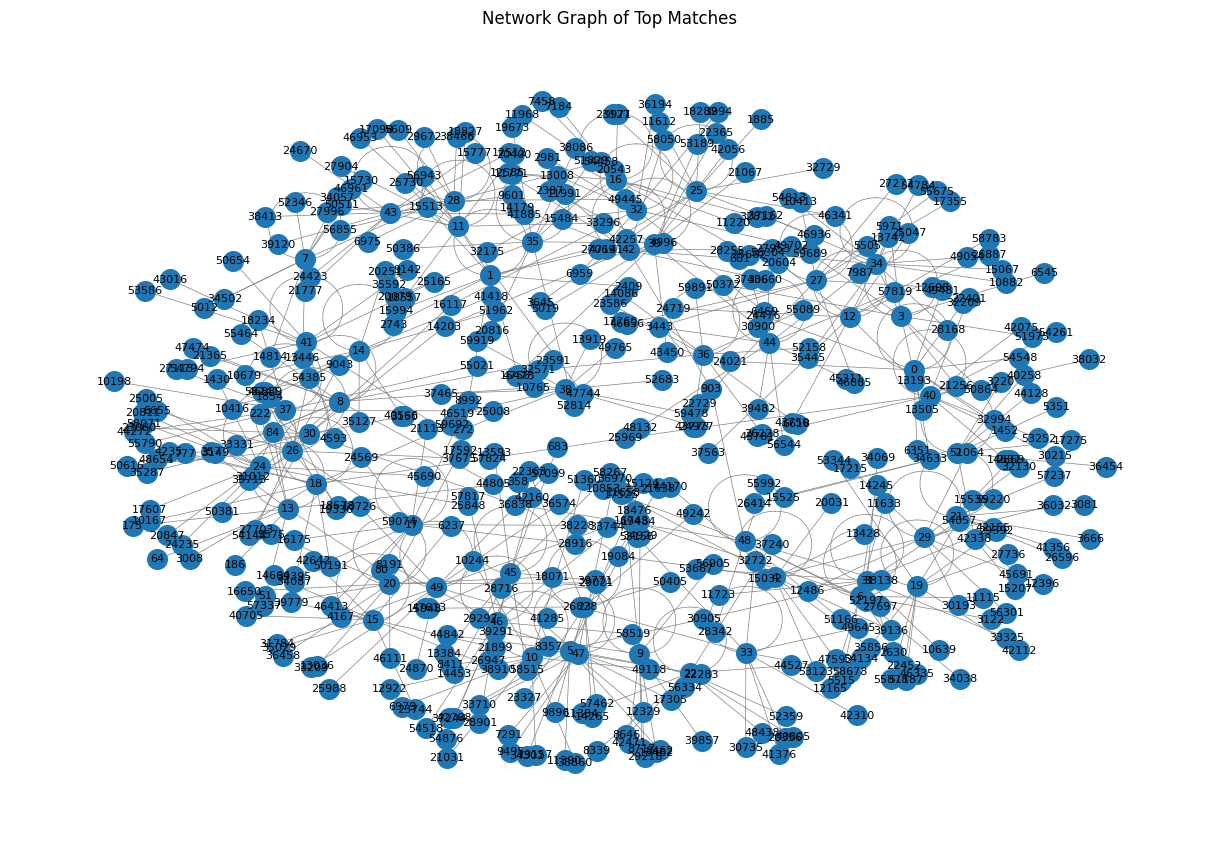

In [ ]:
import networkx as nx

# Create a graph
G = nx.Graph()

# Add nodes and edges for the top matches
subset_size = 50  # Adjust based on your system's memory
for i in range(subset_size):
    for j in range(10):  # Top 10 matches
        G.add_edge(i, indices[i][j], weight=distances[i][j])

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.20)  # Adjust k for better spacing
nx.draw(G, pos, with_labels=True, node_size=200, font_size=8, edge_color='gray', width=0.5)
plt.title('Network Graph of Top Matches')
plt.show()

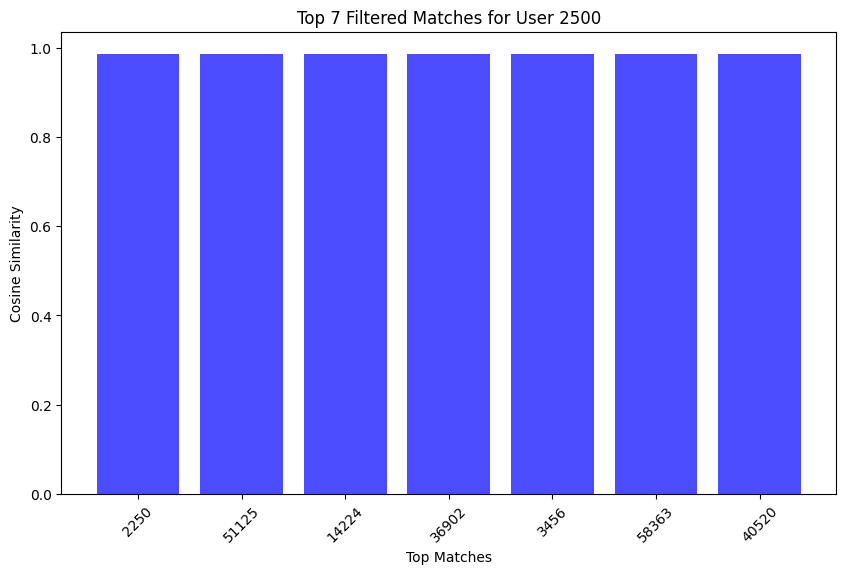

In [ ]:
import matplotlib.pyplot as plt

# Select a user
user_index = 2500  # Replace with the desired user index

# Step 1: Filter matches based on gender and orientation
filtered_matches, filtered_similarities = filter_matches(user_index, indices, distances, okcupid)

# Step 2: Plot the similarity scores for filtered matches
plt.figure(figsize=(10, 6))
plt.bar(range(len(filtered_matches)), filtered_similarities, color='blue', alpha=0.7)
plt.xlabel('Top Matches')
plt.ylabel('Cosine Similarity')
plt.title(f'Top {len(filtered_matches)} Filtered Matches for User {user_index}')
plt.xticks(range(len(filtered_matches)), filtered_matches, rotation=45)
plt.show()

## Save and load preprocessed OKCupid file

In [ ]:
import pandas as pd

# Save the preprocessed DataFrame to a pickle file
okcupid.to_pickle('okcupid_preprocessed.pkl')

In [ ]:
# Load the preprocessed DataFrame from a pickle file
okcupid = pd.read_pickle('okcupid_preprocessed.pkl')

In [ ]:
# Display the unique values and counts for categorical columns
for col in okcupid.select_dtypes(include=['object']).columns:
    print(f"Column: {col}")
    print(okcupid[col].value_counts())
    print()

Column: status
status
single            55697
seeing someone     2064
available          1865
married             310
unknown              10
Name: count, dtype: int64

Column: sex
sex
m    35829
f    24117
Name: count, dtype: int64

Column: orientation
orientation
straight    51606
gay          5573
bisexual     2767
Name: count, dtype: int64

Column: body_type
body_type
average           14652
fit               12711
athletic          11819
unknown            5296
thin               4711
curvy              3924
a little extra     2629
skinny             1777
full figured       1009
overweight          444
jacked              421
used up             355
rather not say      198
Name: count, dtype: int64

Column: drinks
drinks
socially       41780
rarely          5957
often           5164
not at all      3267
unknown         2985
very often       471
desperately      322
Name: count, dtype: int64

Column: drugs
drugs
never        37724
unknown      14080
sometimes     7732
often        

## Manually commpare users

In [ ]:
# Select a user from the test set
val = 2668
user_index = test_user_indices[val]  # Replace with the desired user index

# Get the top matches and their similarity scores
top_k_matches = test_search_indices[val]  # All matches for the first test user
top_k_similarities = test_distances[val]

# Filter matches based on sex and orientation
filtered_matches, filtered_similarities = filter_matches(user_index, top_k_matches, top_k_similarities, okcupid, k=10)

# Get the top 3 filtered matches
top_3_filtered_matches = filtered_matches[:3]
top_3_filtered_similarities = filtered_similarities[:3]

# Get the user's data
user_data = okcupid.loc[user_index]

# Get the data for the top 3 filtered matches
match_data = okcupid.loc[top_3_filtered_matches]

# Combine the user and match data into a single DataFrame
comparison_df = pd.concat([user_data.to_frame().T, match_data], axis=0)

# Add similarity scores to the match data
comparison_df['similarity_score'] = [1.0] + list(top_3_filtered_similarities)  # User has similarity 1.0 with themselves

# Select relevant columns for comparison
columns_to_compare = ['age', 'sex', 'orientation', 'essay0', 'essay1', 'essay2', 'essay3', 'essay4', 'essay5', 'essay6', 'essay7', 'essay8', 'essay9', 'similarity_score']

# Display the comparison table
comparison_df[columns_to_compare]

,age,sex,orientation,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9,similarity_score
57021,47,f,straight,i just realized that all i've ever wanted was ...,"right now, i am planning to do some painting a...","i am really good at staying grounded, looking ...","that i have positive energy, that i am a think...","""the shadow of the wind"", by zafron. ""eat, pra...","1. yoga 2. trail mix 3. my friends, and family...","well, the enviroment and economy. they are int...","just getting off of work, maybe looking for so...","that time is passing, everyday, and i want to ...","there is something cool to do around town, or ...",1.000000
45648,25,m,straight,getting to it maybe later.,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,0.980633
42893,24,m,straight,unknown,starting my career and moving on,unknown,my eyes and smile,unknown,unknown,unknown,unknown,unknown,unknown,0.977613
28670,37,m,straight,unknown,enjoying as much of it as i can one day at a t...,figuring out how things work and fixing it if ...,unknown,i'm a total book worm. i try not to leave home...,family friends food water books internet .......,unknown,"everything, anything, and sometimes absolutely...",i love driving. i can just hop in my car and d...,unknown,0.976391


In [ ]:
f1 = comparison_df.iloc[0]
f1.to_csv('sf2668.csv')
m1 = comparison_df.iloc[-1]
m1.to_csv('sm2668.csv')

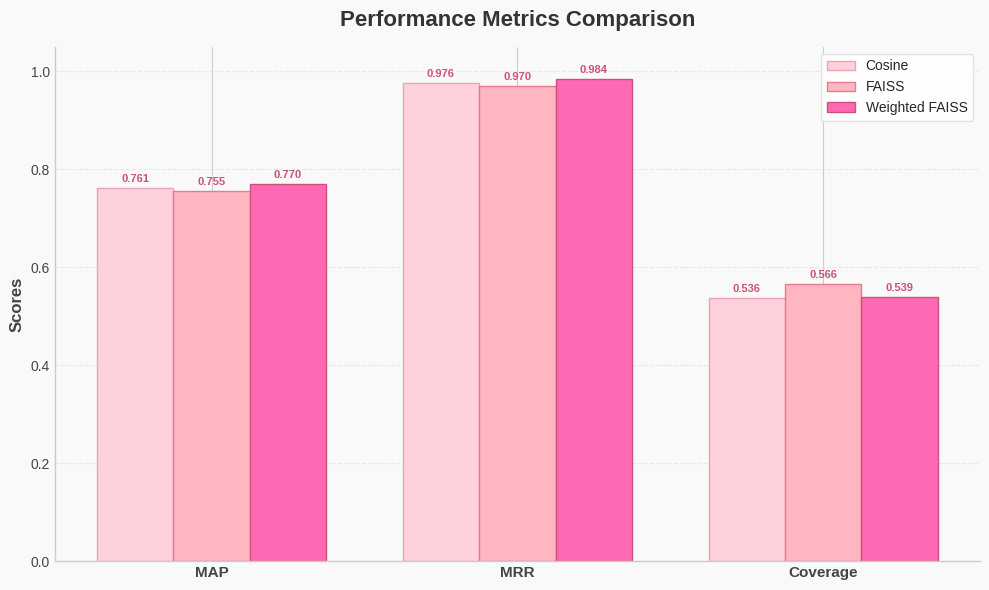

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
import seaborn as sns

# Set the style for a cleaner, more modern look
plt.style.use('seaborn-v0_8-whitegrid')

# Method labels and metric values:
methods = ['Cosine', 'FAISS', 'Weighted FAISS']
map_values   = [0.7608, 0.75499, 0.7699]
mrr_values   = [0.9755, 0.97031, 0.9838]
coverage_values = [0.5364, 0.56633, 0.5392]

# Number of metrics/groups
n_metrics = 3
n_methods = len(methods)

# Set positions for each metric group and each bar within the group
metric_labels = ['MAP', 'MRR', 'Coverage']
x = np.arange(n_metrics)
width = 0.25  # width of each bar

# Create a figure with a light background
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor('#f9f9f9')
ax.set_facecolor('#f9f9f9')

# Define pink color palette (from light to dark pink)
pink_colors = ['#FFD1DC', '#FFB6C1', '#FF69B4']

# Plot bars for each method with different shades of pink
rects1 = ax.bar(x - width, [map_values[0], mrr_values[0], coverage_values[0]],
               width, label=methods[0], color=pink_colors[0], edgecolor='#E6A5B0', linewidth=1)
rects2 = ax.bar(x, [map_values[1], mrr_values[1], coverage_values[1]],
               width, label=methods[1], color=pink_colors[1], edgecolor='#E67A92', linewidth=1)
rects3 = ax.bar(x + width, [map_values[2], mrr_values[2], coverage_values[2]],
               width, label=methods[2], color=pink_colors[2], edgecolor='#CC5278', linewidth=1)

# Style improvements
ax.set_ylabel('Scores', fontsize=12, fontweight='bold', color='#444444')
ax.set_title('Performance Metrics Comparison', fontsize=16, fontweight='bold', color='#333333', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(metric_labels, fontsize=11, fontweight='semibold')
ax.tick_params(axis='both', colors='#444444')

# Customize y-axis
ax.set_ylim(0, 1.05)  # Set y-axis limit with a bit of padding
ax.spines['top'].set_visible(False)  # Remove top spine
ax.spines['right'].set_visible(False)  # Remove right spine
ax.spines['left'].set_color('#cccccc')  # Lighten left spine
ax.spines['bottom'].set_color('#cccccc')  # Lighten bottom spine

# Customize legend
legend = ax.legend(frameon=True, fancybox=True, framealpha=0.9,
                  facecolor='white', edgecolor='#e0e0e0',
                  fontsize=10, loc='upper right')

# Add value labels on top of bars with improved formatting
def autolabel(rects, color='#333333'):
    """Attach a text label above each bar displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8,
                    fontweight='semibold', color=color)

autolabel(rects1, '#CC5278')
autolabel(rects2, '#CC5278')
autolabel(rects3, '#CC5278')

# Add a light grid for readability, but only on the y-axis
ax.grid(axis='y', linestyle='--', alpha=0.7, color='#e0e0e0')

plt.tight_layout()
plt.savefig("performance_metrics_pink.png", dpi=300, bbox_inches='tight')  # Higher resolution save
plt.show()

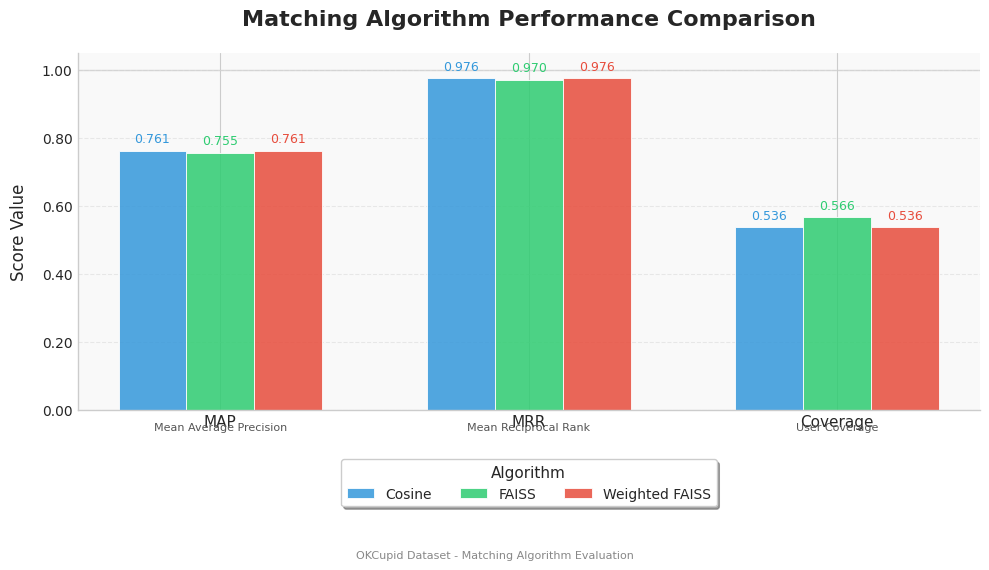

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
import seaborn as sns

# Set the style for a cleaner, more modern look
plt.style.use('seaborn-v0_8-whitegrid')

# Method labels and metric values:
methods = ['Cosine', 'FAISS', 'Weighted FAISS']
map_values   = [0.7608, 0.75499, 0.7608]
mrr_values   = [0.9755, 0.97031, 0.9755]
coverage_values = [0.5364, 0.56633, 0.5364]

# Number of metrics/groups
n_metrics = 3
n_methods = len(methods)

# Set positions for each metric group and each bar within the group
metric_labels = ['MAP', 'MRR', 'Coverage']
x = np.arange(n_metrics)
width = 0.25  # width of each bar

# Create a figure with a light background
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor('#f9f9f9')
ax.set_facecolor('#f9f9f9')

# Define pink color palette (from light to dark pink)
pink_colors = ['#FFD1DC', '#FFB6C1', '#FF69B4']

# Plot bars for each method with different shades of pink
rects1 = ax.bar(x - width, [map_values[0], mrr_values[0], coverage_values[0]],
               width, label=methods[0], color=pink_colors[0], edgecolor='#E6A5B0', linewidth=1)
rects2 = ax.bar(x, [map_values[1], mrr_values[1], coverage_values[1]],
               width, label=methods[1], color=pink_colors[1], edgecolor='#E67A92', linewidth=1)
rects3 = ax.bar(x + width, [map_values[2], mrr_values[2], coverage_values[2]],
               width, label=methods[2], color=pink_colors[2], edgecolor='#CC5278', linewidth=1)

# Style improvements
ax.set_ylabel('Scores', fontsize=12, fontweight='bold', color='#444444')
ax.set_title('Performance Metrics Comparison', fontsize=16, fontweight='bold', color='#333333', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(metric_labels, fontsize=11, fontweight='semibold')
ax.tick_params(axis='both', colors='#444444')

# Customize y-axis
ax.set_ylim(0, 1.05)  # Set y-axis limit with a bit of padding
ax.spines['top'].set_visible(False)  # Remove top spine
ax.spines['right'].set_visible(False)  # Remove right spine
ax.spines['left'].set_color('#cccccc')  # Lighten left spine
ax.spines['bottom'].set_color('#cccccc')  # Lighten bottom spine

# Customize legend
legend = ax.legend(frameon=True, fancybox=True, framealpha=0.9,
                  facecolor='white', edgecolor='#e0e0e0',
                  fontsize=10, loc='upper right')

# Add value labels on top of bars with improved formatting
def autolabel(rects, color='#333333'):
    """Attach a text label above each bar displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8,
                    fontweight='semibold', color=color)

autolabel(rects1, '#CC5278')
autolabel(rects2, '#CC5278')
autolabel(rects3, '#CC5278')

# Add a light grid for readability, but only on the y-axis
ax.grid(axis='y', linestyle='--', alpha=0.7, color='#e0e0e0')

plt.tight_layout()
plt.savefig("performance_metrics_pink.png", dpi=300, bbox_inches='tight')  # Higher resolution save
plt.show()